# <a id='toc1_'></a>[investigating Spotify Using PySpark](#toc0_)

## <a id='toc1_1_'></a>[Authors](#toc0_)
* **Alireza Arbabi**
* **Hadi Babalou**
* **Ali Padyav**
* **Kasra Hajiheidari**

## <a id='toc1_2_'></a>[Table of Contents](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [investigating Spotify Using PySpark](#toc1_)    
  - [Authors](#toc1_1_)    
  - [Table of Contents](#toc1_2_)    
  - [Setting Up the Environment](#toc1_3_)    
  - [Loading the Data](#toc1_4_)    
  - [Schema of the Data](#toc1_5_)    
  - [Preprocessing the Data](#toc1_6_)    
    - [Missing Values](#toc1_6_1_)    
    - [Duplicates](#toc1_6_2_)    
    - [Type Conversions](#toc1_6_3_)    
    - [Outliers](#toc1_6_4_)    
    - [Feature Engineering](#toc1_6_5_)    
  - [Features Correlation](#toc1_7_)    
  - [Features Distribution](#toc1_8_)    
    - [Explicit](#toc1_8_1_)    
    - [Danceability](#toc1_8_2_)    
    - [Energy](#toc1_8_3_)    
    - [Key](#toc1_8_4_)    
    - [Loudness](#toc1_8_5_)    
    - [Mode](#toc1_8_6_)    
    - [Speechiness](#toc1_8_7_)    
    - [Acousticness](#toc1_8_8_)    
    - [Instrumentalness](#toc1_8_9_)    
    - [Liveness](#toc1_8_10_)    
    - [Valence](#toc1_8_11_)    
    - [Tempo](#toc1_8_12_)    
    - [Duration](#toc1_8_13_)    
    - [Time Signature](#toc1_8_14_)    
    - [Year](#toc1_8_15_)    
    - [Decade](#toc1_8_16_)    
    - [Quarter](#toc1_8_17_)    
    - [Month](#toc1_8_18_)    
    - [Week](#toc1_8_19_)    
    - [Day](#toc1_8_20_)    
    - [Weekday](#toc1_8_21_)    
  - [Top Records](#toc1_9_)    
    - [The Most Danceable Songs](#toc1_9_1_)    
    - [The Most Valence Songs](#toc1_9_2_)    
    - [The Least Valence Songs](#toc1_9_3_)    
    - [The Most Energetic Songs](#toc1_9_4_)    
    - [The Loudest Songs](#toc1_9_5_)    
    - [The Quietest Songs](#toc1_9_6_)    
    - [The Longest Songs](#toc1_9_7_)    
    - [The Shortest Songs](#toc1_9_8_)    
    - [Songs with the Highest Tempo](#toc1_9_9_)    
    - [Songs with the Lowest Tempo](#toc1_9_10_)    
    - [The Oldest Songs](#toc1_9_11_)    
    - [Artists with the Most Songs](#toc1_9_12_)    
    - [Artists with the Most Albums](#toc1_9_13_)    
    - [Albums with the Most Songs](#toc1_9_14_)    
    - [Albums with the Most Artists](#toc1_9_15_)    
    - [Artists with the Most Explicit Songs](#toc1_9_16_)    
    - [Artists with the Most Danceable Songs](#toc1_9_17_)    
    - [Artists with the Loudest Songs](#toc1_9_18_)    
  - [Trends Over Time](#toc1_10_)    
    - [Features Average Trends over Time](#toc1_10_1_)    
    - [Average of Feature Over Decades](#toc1_10_2_)    
    - [Number of Releases Over Time](#toc1_10_3_)    
  - [Other Interesting Insights](#toc1_11_)    
    - [Benford's law](#toc1_11_1_)    
  - [Clustering](#toc1_12_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_3_'></a>[Setting Up the Environment](#toc0_)

In [1]:
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install tqdm
!pip install scipy
!pip install pyspark

In [158]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from scipy import stats

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, avg, count, countDistinct
from pyspark.sql.functions import split, explode, when, regexp_extract, substring
from pyspark.sql.functions import date_format, dayofweek, dayofyear, weekofyear, quarter
from pyspark.sql.functions import corr
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

import warnings
warnings.filterwarnings("ignore")

In [3]:
from IPython.display import display, HTML
display(HTML('<style>pre { white-space: pre !important; }</style>'))

## <a id='toc1_4_'></a>[Loading the Data](#toc0_)

In [4]:
DATA_PATH = 'spotify.parquet'

In [5]:
spark = SparkSession.builder.appName('spotify').getOrCreate()
df = spark.read.parquet(DATA_PATH)

24/04/17 14:14:24 WARN Utils: Your hostname, hadi resolves to a loopback address: 127.0.1.1; using 192.168.99.179 instead (on interface wlp2s0)
24/04/17 14:14:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/17 14:14:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
def show(df, n=1):
	print(f'Number of rows: {df.count()}')
	df.show(n)

In [7]:
show(df, n=5)

Number of rows: 1204025
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+------------------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----+------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|danceability|energy|key|          loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|time_signature|year|release_date|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+------------------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----+------------+
|7lmeHLHBe

## <a id='toc1_5_'></a>[Schema of the Data](#toc0_)

In [8]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- artist_ids: string (nullable = true)
 |-- track_number: long (nullable = true)
 |-- disc_number: long (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: long (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: long (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- year: long (nullable = true)
 |-- release_date: string (nullable = true)



The spotify dataset contains the following information about the songs:

- **id**: The unique identifier of the song.

- **name**: The name of the song.
- **album**: The name of the album that the song belongs to.
- **album_id**: The unique identifier of the album.
- **artists**: The name of the artist(s) who performed the song. If there are multiple artists, they are separated by a comma.
- **artist_ids**: The unique identifier of the artist(s). If there are multiple artists, they are separated by a comma.
- **track_number**: The position of the song in the album.
- **disc_number**: The disc number of the album. If the album has multiple discs, they are numbered sequentially.
- **explicit**: A boolean value indicating whether the song contains explicit content. `1` means the song contains explicit content, `0` means it does not.
- **danceability**: A measure of how suitable a song is for dancing. A value of `0.0` is least danceable and `1.0` is most danceable.
- **energy**: A measure of the intensity and activity of the song. A value of `0.0` is least energetic and `1.0` is most energetic.
- **key**: The key of the song. The key identifies the tonic triad, the chord, major or minor, which represents the final point of rest or resolution for a piece, or the focal point of a section.
- **loudness**: The loudness of the song in Loudness Units Relative to Full Scale (LUFS). LUFS is a unit of measurement for loudness that takes into account the human perception of loudness. A value of `0.0` is least loud and negative values are quieter. The typical range of loudness for music is around -20 to -10 LUFS. 
- **mode**: The modality of the song. Modality is the type of scale from which the melodic content of a musical composition is derived. `1` represents major, `0` represents minor.
- **speechiness**: A measure of the presence of spoken words in the song. A value of `0.0` is least speechy and `1.0` is most speechy.
- **acousticness**: A measure of the amount of acoustic sounds in the song. A value of `0.0` is least acoustic and `1.0` is most acoustic.
- **instrumentalness**: A measure of the amount of instrumental sounds in the song. A value of `0.0` is least instrumental and `1.0` is most instrumental.
- **liveness**: A measure of the presence of a live audience in the song. A value of `0.0` is least live and `1.0` is most live.
- **valence**: A measure of the musical positiveness conveyed by the song. A value of `0.0` is least positive and `1.0` is most positive.
- **tempo**: The tempo of the song in beats per minute. Tempo is the speed or pace of a given piece and derives directly from the average beat duration.
- **duration_ms**: The duration of the song in milliseconds.
- **time_signature**: The time signature of the song. The time signature is a notational convention used in Western musical notation to specify how many beats are in each bar and which note value constitutes one beat. For example, a time signature of `4/4` indicates that there are 4 beats in each bar and that each beat is a quarter note.
- **year**: The year the song was released.
- **release_date**: The release date of the song. The release date is in the format `YYYY-MM-DD`.


## <a id='toc1_6_'></a>[Preprocessing the Data](#toc0_)

### <a id='toc1_6_1_'></a>[Missing Values](#toc0_)

In [9]:
def calculate_nulls(df):
	null_counts = df.select(*(sum(col(c).isNull().cast("int")).alias(c) for c in df.columns))
	return null_counts

show(calculate_nulls(df))

Number of rows: 1


+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----+------------+
| id|name|album|album_id|artists|artist_ids|track_number|disc_number|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|duration_ms|time_signature|year|release_date|
+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----+------------+
|  0|   3|   11|       0|      0|         0|           0|          0|       0|           0|     0|  0|       0|   0|          0|           0|               0|       0|      0|    0|          0|             0|   0|           0|
+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+-

As we can see from the table below, there are 3 missing values in the `name` column and 11 missing values in the `album` column. Because of the small number of missing values with respect to the total number of rows in the dataset, we can safely drop these rows.

In [10]:
df = df.dropna(subset=['name', 'album'])
show(calculate_nulls(df))

Number of rows: 1


+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----+------------+
| id|name|album|album_id|artists|artist_ids|track_number|disc_number|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|duration_ms|time_signature|year|release_date|
+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----+------------+
|  0|   0|    0|       0|      0|         0|           0|          0|       0|           0|     0|  0|       0|   0|          0|           0|               0|       0|      0|    0|          0|             0|   0|           0|
+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+-

### <a id='toc1_6_2_'></a>[Duplicates](#toc0_)

In [11]:
show(df.groupBy('id').count().filter(col('count') > 1))

24/04/17 14:14:38 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Number of rows: 0


+---+-----+
| id|count|
+---+-----+
+---+-----+



As we can see, there are no duplicate rows in the dataset.

### <a id='toc1_6_3_'></a>[Type Conversions](#toc0_)

First we will convert the `release_date` column to a `DateType` column.

In [12]:
df = df.withColumn('release_date', col('release_date').cast('date'))
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- artist_ids: string (nullable = true)
 |-- track_number: long (nullable = true)
 |-- disc_number: long (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: long (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: long (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- year: long (nullable = true)
 |-- release_date: date (nullable = true)



Also, we should convert `artists` and `artists_ids` from `String` to `List`

In [13]:
df = df.withColumn('artists', split(regexp_extract(col('artists'), r'\[(.*)\]', 1), ', '))
show(df)

Number of rows: 1204012
+--------------------+-------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----+------------+
|                  id|   name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|time_signature|year|release_date|
+--------------------+-------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----+------------+
|7lmeHLHBe4nmXzuXc...|Testify|The Battle Of Los...|2eia0myWFgoHuttJy...|['Rage 

In [14]:
df = df.withColumn('artist_ids', split(regexp_extract(col('artist_ids'), r'\[(.*)\]', 1), ', '))
show(df)

Number of rows: 1204012
+--------------------+-------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----+------------+
|                  id|   name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|time_signature|year|release_date|
+--------------------+-------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----+------------+
|7lmeHLHBe4nmXzuXc...|Testify|The Battle Of Los...|2eia0myWFgoHuttJy...|['Rage 

### <a id='toc1_6_4_'></a>[Outliers](#toc0_)

Identifying and handling outliers is an important step in the data preprocessing phase. Outliers can have a significant impact on the results of the analysis and can lead to incorrect conclusions. In this section, we will identify and handle outliers in the dataset.

In [15]:
show(df.filter(col('year') < 1900), n=20)

Number of rows: 10
+--------------------+-----------------+----------+--------------------+-----------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+----+-----------+------------------+------------------+--------+------------------+------------------+-----------+--------------+----+------------+
|                  id|             name|     album|            album_id|    artists|          artist_ids|track_number|disc_number|explicit|      danceability|            energy|key|           loudness|mode|speechiness|      acousticness|  instrumentalness|liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|
+--------------------+-----------------+----------+--------------------+-----------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+----+-----------+------------------+------------------+--------+------------------

As we can see in the above results, there is an album with release date `0000-01-01` which is not a valid date. 
We will replace this value with the correct value obtained from internet. 

In [16]:
# change the release date of 'Optimism 2' by iCizzle to September 4, 2018
df = df.withColumn('release_date', when(col('album') == 'Optimism 2', '2018-09-04').otherwise(col('release_date')))
df = df.withColumn('year', when(col('album') == 'Optimism 2', 2018).otherwise(col('year')))

The other potential outliers are extremely short or long tracks.

In [153]:
MINS_TO_MS = 60 * 1000
MIN_DURATION_TO_KEEP = 0.5
MAX_DURATION_TO_KEEP = 15

In [155]:
show(df.filter(col('duration_ms') < MIN_DURATION_TO_KEEP * MINS_TO_MS).orderBy('duration_ms', ascending=True), n=10)

Number of rows: 0


+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----+------------+-----+---+-----------+----+-------+-----------+------+-------------+
| id|name|album|album_id|artists|artist_ids|track_number|disc_number|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|duration_ms|time_signature|year|release_date|month|day|day_of_week|week|quarter|day_of_year|decade|duration_mins|
+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----+------------+-----+---+-----------+----+-------+-----------+------+-------------+
+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------+---+--------+----

The songs shorther than `MIN_DURATION_TO_KEEP` are typically not songs and are likely to be skits, ads, or other non-musical content. We will remove these songs from the dataset.

In [18]:
df = df.filter(col('duration_ms') >= 0.5 * MINS_TO_MS)

In [156]:
show(df.filter(col('duration_ms') > MAX_DURATION_TO_KEEP * MINS_TO_MS).orderBy('duration_ms', ascending=False), n=10)

Number of rows: 0
+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----+------------+-----+---+-----------+----+-------+-----------+------+-------------+
| id|name|album|album_id|artists|artist_ids|track_number|disc_number|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|duration_ms|time_signature|year|release_date|month|day|day_of_week|week|quarter|day_of_year|decade|duration_mins|
+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----+------------+-----+---+-----------+----+-------+-----------+------+-------------+
+---+----+-----+--------+-------+----------+------------+-----------+--------+------------+------

24/04/17 21:51:20 WARN TransportChannelHandler: Exception in connection from /192.168.99.179:46403
java.io.IOException: Connection timed out
	at java.base/sun.nio.ch.SocketDispatcher.read0(Native Method)
	at java.base/sun.nio.ch.SocketDispatcher.read(SocketDispatcher.java:47)
	at java.base/sun.nio.ch.IOUtil.readIntoNativeBuffer(IOUtil.java:340)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:294)
	at java.base/sun.nio.ch.IOUtil.read(IOUtil.java:269)
	at java.base/sun.nio.ch.SocketChannelImpl.read(SocketChannelImpl.java:425)
	at io.netty.buffer.PooledByteBuf.setBytes(PooledByteBuf.java:254)
	at io.netty.buffer.AbstractByteBuf.writeBytes(AbstractByteBuf.java:1132)
	at io.netty.channel.socket.nio.NioSocketChannel.doReadBytes(NioSocketChannel.java:357)
	at io.netty.channel.nio.AbstractNioByteChannel$NioByteUnsafe.read(AbstractNioByteChannel.java:151)
	at io.netty.channel.nio.NioEventLoop.processSelectedKey(NioEventLoop.java:788)
	at io.netty.channel.nio.NioEventLoop.processSelectedKeysOpt

The songs longer than `MAX_DURATION_TO_KEEP` are typically not songs and are likely to be audiobooks, podcasts, or other long-form content. We will remove these songs from the dataset.

In [19]:
df = df.filter(col('duration_ms') <= 15 * MINS_TO_MS)

### <a id='toc1_6_5_'></a>[Feature Engineering](#toc0_)

We can extract the month, day, weekday, week, day of the year, and quarter from the `release_date` column to create new columns.

In [20]:
df = df.withColumn('month', split(col('release_date'), '-')[1].cast('int'))
df = df.withColumn('day', split(col('release_date'), '-')[2].cast('int'))
df = df.withColumn('day_of_week', date_format(col('release_date'), 'EEEE'))
df = df.withColumn('week', weekofyear(col('release_date')))
df = df.withColumn('quarter', quarter(col('release_date')))
df = df.withColumn('day_of_year', dayofyear(col('release_date')))
df = df.withColumn('decade', (col('year') - col('year') % 10).cast('int'))
show(df)

Number of rows: 1188345


24/04/17 14:14:47 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----+------------+-----+---+-----------+----+-------+-----------+------+
|                  id|   name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|time_signature|year|release_date|month|day|day_of_week|week|quarter|day_of_year|decade|
+--------------------+-------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----+---------

In [21]:
df = df.withColumn('duration_mins', col('duration_ms') / 60000)

In [22]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- artists: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- artist_ids: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- track_number: long (nullable = true)
 |-- disc_number: long (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: long (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: long (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- year: long (nul

## <a id='toc1_7_'></a>[Features Correlation](#toc0_)

24/04/17 14:14:54 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/04/17 14:14:54 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


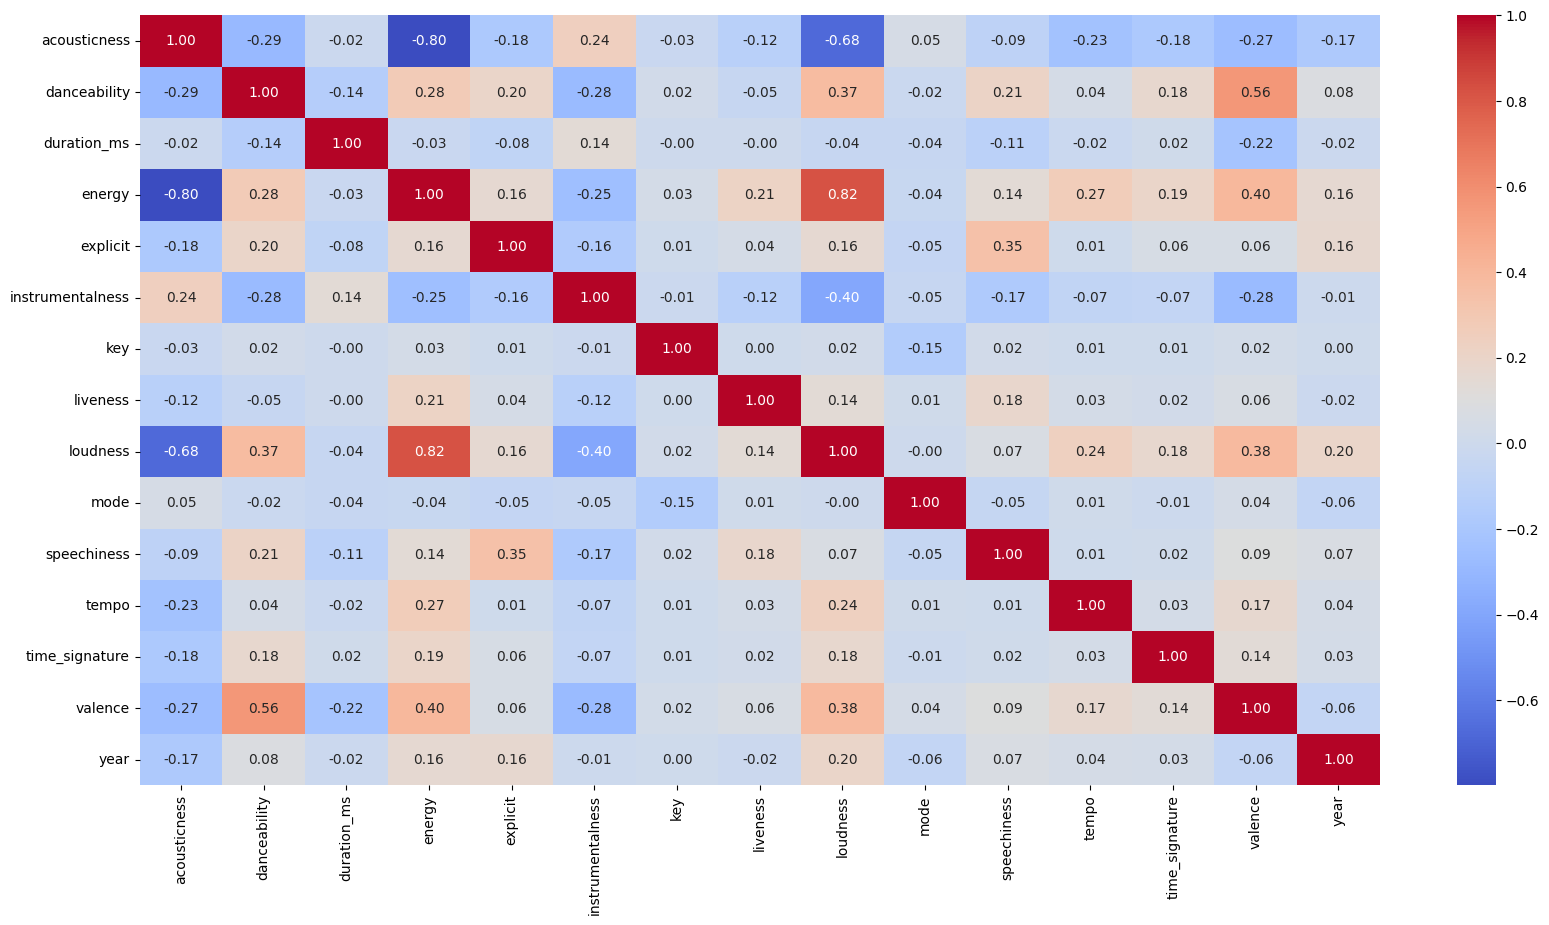

In [23]:
def plot_correlation_matrix(df, columns, figsize=(20, 10)):
	assembler = VectorAssembler(inputCols=columns, outputCol='features')
	assembled_df = assembler.transform(df)
	pearson_corr = Correlation.corr(assembled_df, 'features').collect()[0][0]
	corr_df = pd.DataFrame(pearson_corr.toArray(), columns=columns, index=columns)
	plt.figure(figsize=figsize)
	sns.heatmap(corr_df, annot=True, cmap='coolwarm', fmt=".2f")
	plt.show()
	return corr_df

numeric_columns = ['acousticness', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 'year']
corr_df = plot_correlation_matrix(df, columns=numeric_columns)

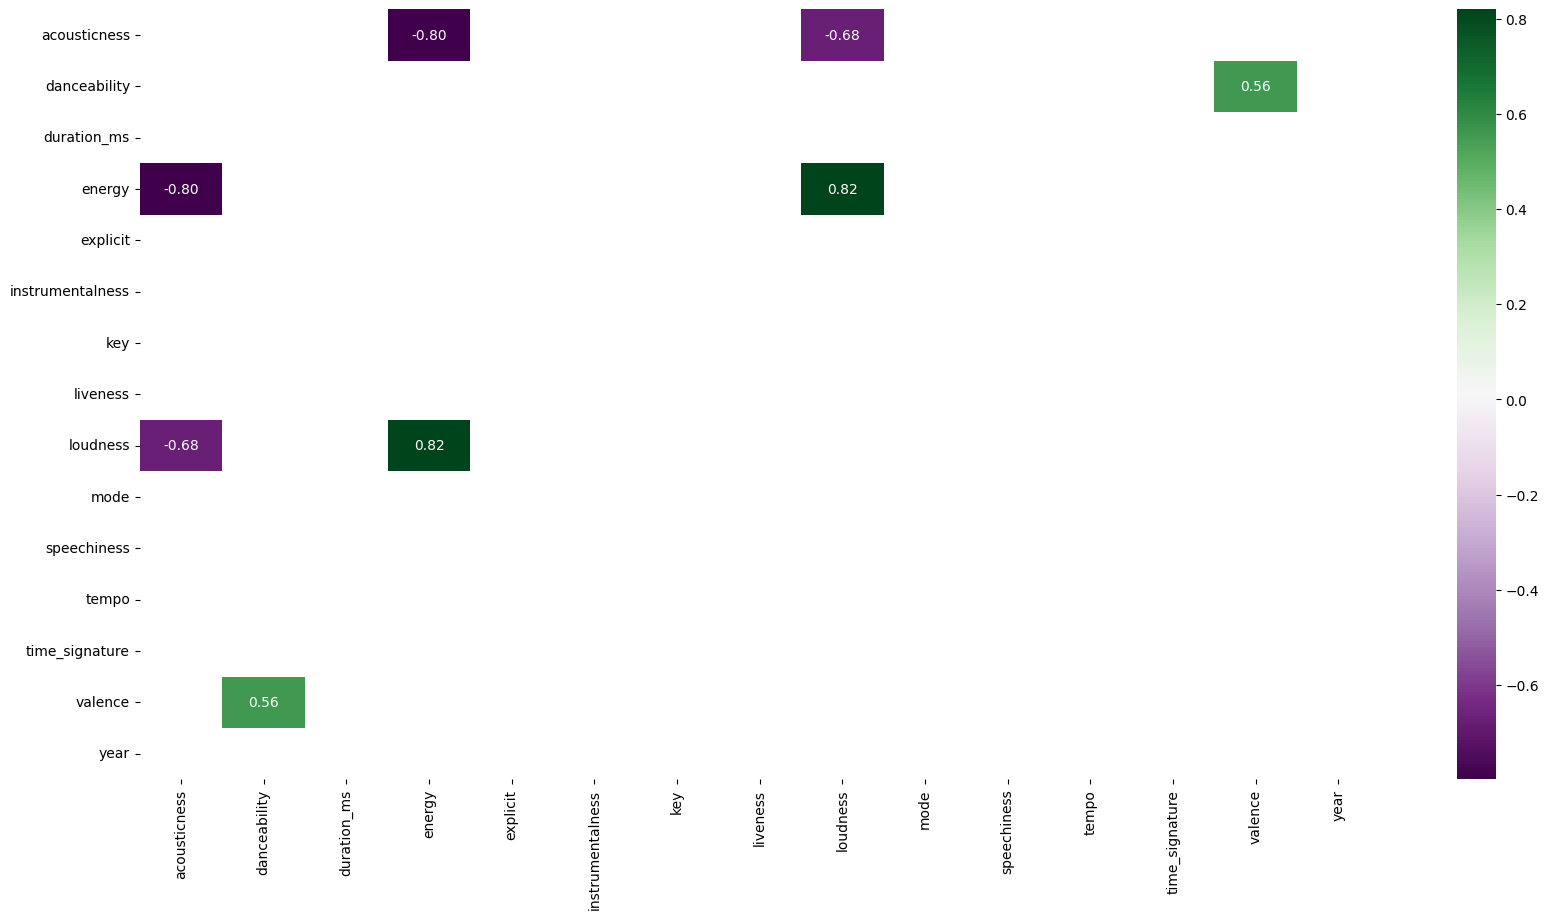

In [24]:
def plot_filtered_correlation_matrix(corr_df, threshold=0.5, figsize=(20, 10)):
	filtered_corr_df = corr_df[((corr_df > threshold) | (corr_df < -threshold)) & (corr_df != 1.0)]
	plt.figure(figsize=figsize)
	sns.heatmap(filtered_corr_df, annot=True, cmap='PRGn', fmt=".2f")
	plt.show()

plot_filtered_correlation_matrix(corr_df, threshold=0.5)

As we can see, the `energy` and `loudness` columns have a high positive correlation of `0.82`. This is expected because songs with higher energy levels tend to be louder. 

The `energy` and `acousticness` columns have a high negative correlation of `-0.80`. This is also expected because songs with higher energy levels tend to have lower acousticness levels. 

The `loudness` and `acousticness` columns have a high negative correlation of `-0.67`. This is also expected because songs with higher loudness levels tend to have lower acousticness levels. 

Also, the `danceability` and `valence` columns have a high positive correlation of `0.56`. This is expected because songs that are more danceable tend to have higher valence levels.

## <a id='toc1_8_'></a>[Features Distribution](#toc0_)

In [104]:
def count_plot(df, col_name, figsize=(12, 6), sorted=True, step=None):
	plt.figure(figsize=figsize)
	if sorted:
		sns.countplot(data=df.select(col_name).toPandas(), x=col_name, order=df.groupBy(col_name).count().orderBy('count', ascending=False).toPandas()[col_name], color='deepskyblue', alpha=0.5)
	else:
		sns.countplot(data=df.select(col_name).toPandas(), x=col_name, color='deepskyblue', alpha=0.5)
	plt.xlabel(col_name)
	plt.ylabel('Count')
	plt.title(f'{col_name} Count Plot')
	if step is not None:
		plt.xticks(ticks=plt.xticks()[0][::step])
	plt.show()

In [26]:
def box_plot(df, x, figsize=(6, 8)):
	plt.figure(figsize=figsize)
	sns.boxplot(data=df.select(x).toPandas(), y=x, color='deepskyblue', showmeans=True, meanline=True, meanprops={'linestyle': '--', 'color': 'red'})
	plt.title(f'{x} Box Plot')
	plt.show()

In [27]:
def violin_plot(df, x, figsize=(6, 8)):
	plt.figure(figsize=figsize)
	sns.violinplot(data=df.select(x).toPandas(), y=x, color='deepskyblue', inner='quartile', alpha=0.5)
	plt.title(f'{x} Violin Plot')
	plt.show()

In [28]:
def hist_plot(df, col_name, bins=None, figsize=(12, 6), kde=True, normal_estimation=True, rule='struges', stat='count'):
	target_column = df.select(col_name)
	if bins is None:
		if rule == 'sturges':
			bins = int(1 + 3.322 * np.log10(target_column.count()))
		elif rule == 'rice':
			bins = int(2 * target_column.count() ** (1/3))
		elif rule == 'doane':
			bins = int(1 + np.log2(target_column.count()) + np.log2(1 + abs(np.corrcoef(target_column.values.T)[0][1])))
		elif rule == 'scott':
			bins = int(3.5 * np.std(target_column.toPandas().values) / (target_column.count() ** (1/3)))
		elif rule == 'sqrt':
			bins = int(np.sqrt(target_column.count()))
		else:
			bins = 10

	target_column = target_column.toPandas()
	plt.figure(figsize=figsize)
	hist_plot = sns.histplot(data=target_column, x=col_name, bins=bins, color='deepskyblue', kde=kde, alpha=0.5, stat=stat)
	if normal_estimation:
		mu, sigma = target_column.mean(), target_column.std()
		x = np.linspace(mu - 3 * sigma, mu + 3 * sigma, 100)
		y = stats.norm.pdf(x, mu, sigma)
		scale_factor = hist_plot.get_yticks().max() / y.max()
		y = y * scale_factor
		plt.plot(x, y, color='deeppink', linewidth=2, alpha=0.5)
		
	plt.xlabel(col_name)
	plt.ylabel('Count')
	plt.title(f'{col_name} Histogram Plot')
	if normal_estimation:
		plt.legend(['Kernel Density Estimation', 'Normal Distribution'])
	plt.show()

### <a id='toc1_8_1_'></a>[Explicit](#toc0_)

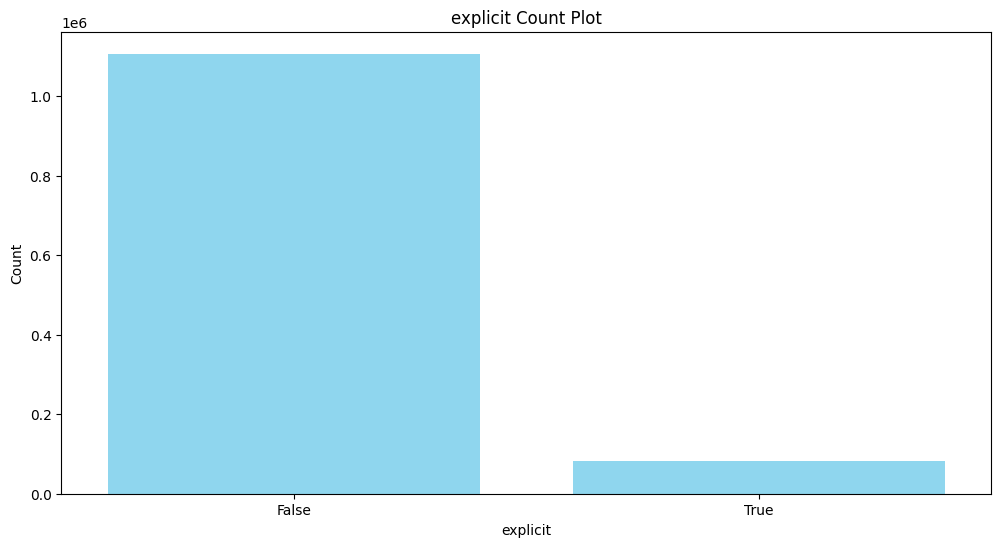

In [29]:
count_plot(df, 'explicit')

### <a id='toc1_8_2_'></a>[Danceability](#toc0_)

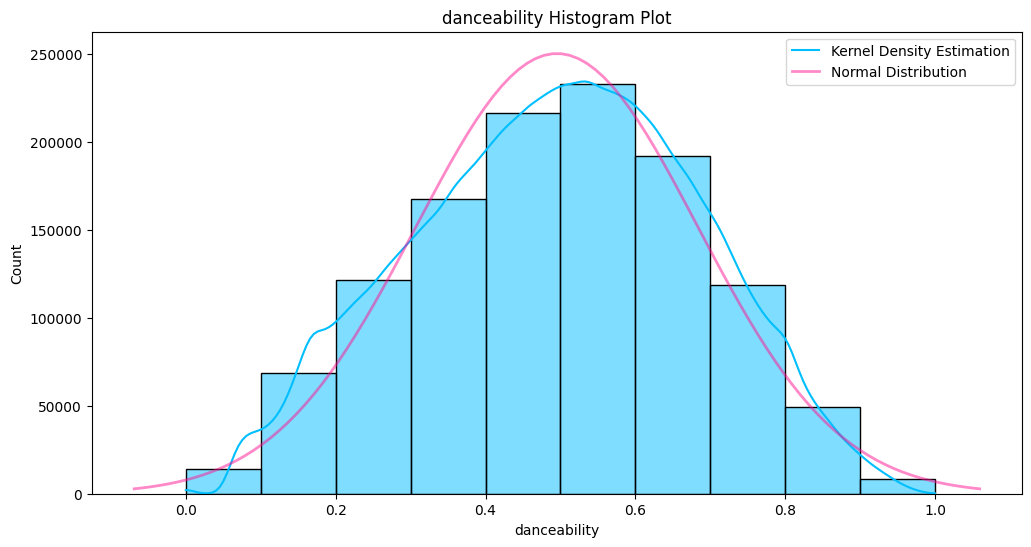

In [30]:
hist_plot(df, 'danceability')

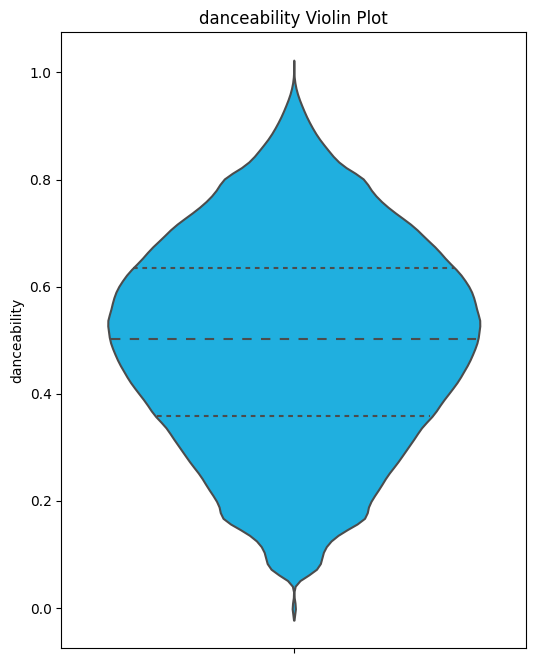

In [31]:
violin_plot(df, 'danceability')

### <a id='toc1_8_3_'></a>[Energy](#toc0_)

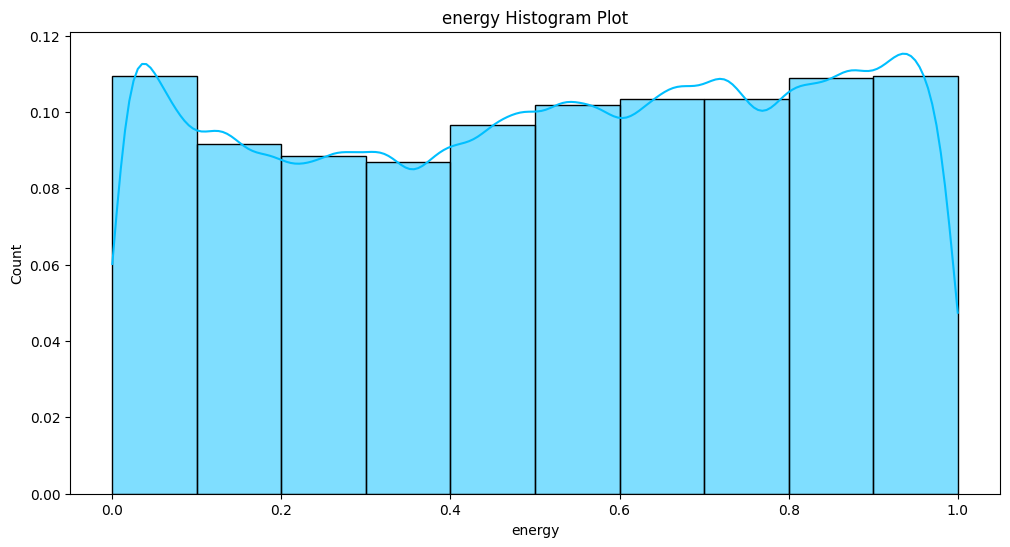

In [32]:
hist_plot(df, 'energy', normal_estimation=False, stat='proportion')

### <a id='toc1_8_4_'></a>[Key](#toc0_)

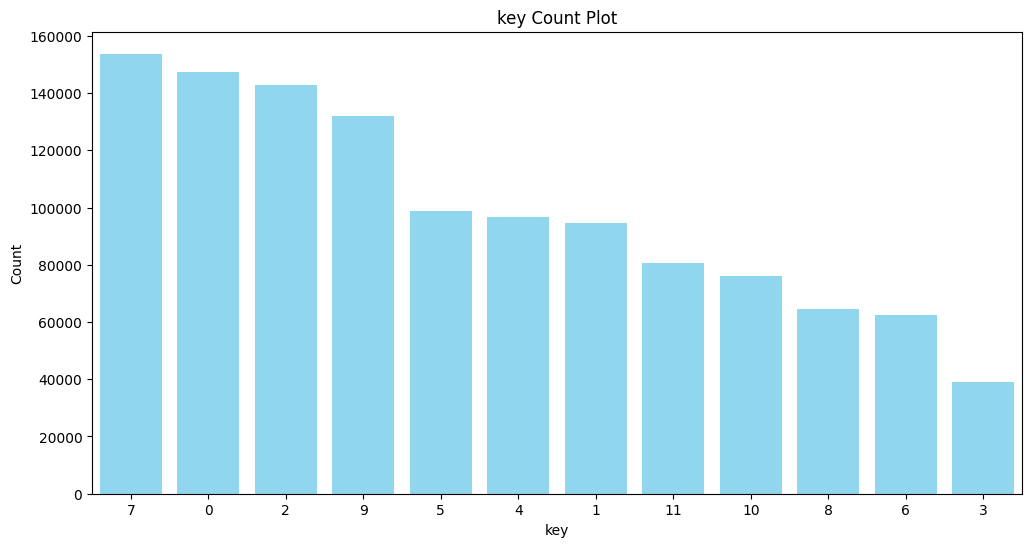

In [33]:
count_plot(df, 'key')

### <a id='toc1_8_5_'></a>[Loudness](#toc0_)

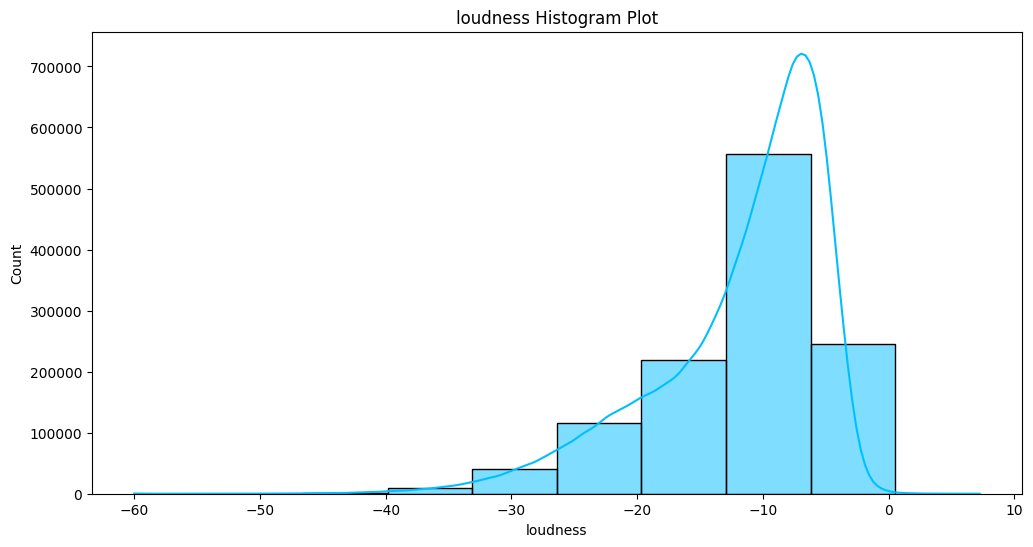

In [34]:
hist_plot(df, 'loudness', normal_estimation=False)

### <a id='toc1_8_6_'></a>[Mode](#toc0_)

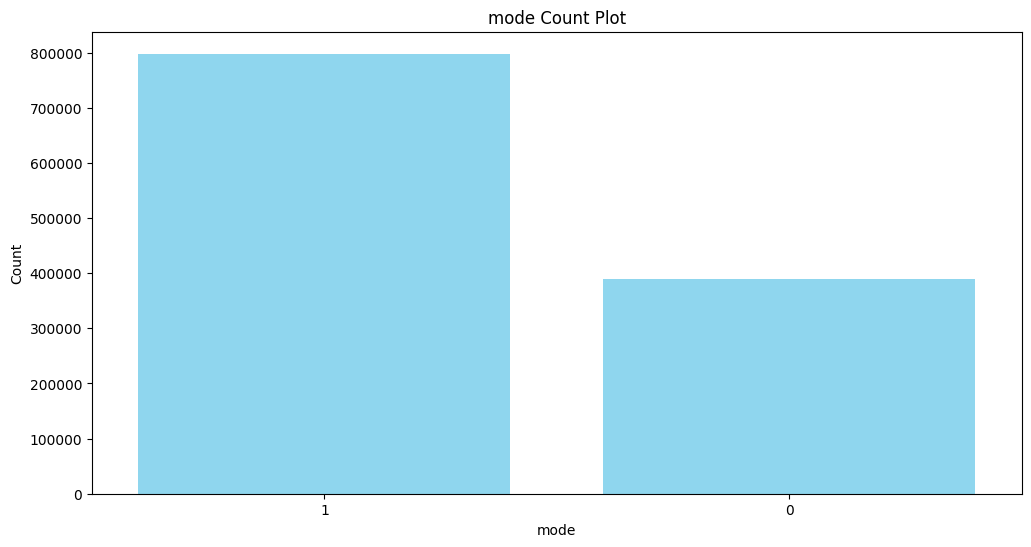

In [35]:
count_plot(df, 'mode')

### <a id='toc1_8_7_'></a>[Speechiness](#toc0_)

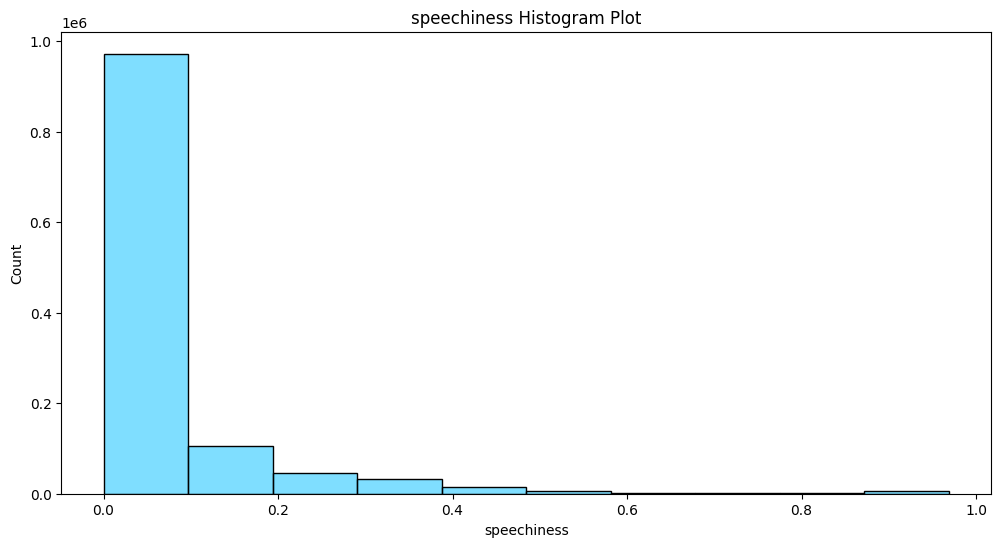

In [36]:
hist_plot(df, 'speechiness', kde=False, normal_estimation=False)

The distribution of speechiness seems to be skewed toward lower values. This is expected because most songs are primarily instrumental and contain little to no spoken words.

### <a id='toc1_8_8_'></a>[Acousticness](#toc0_)

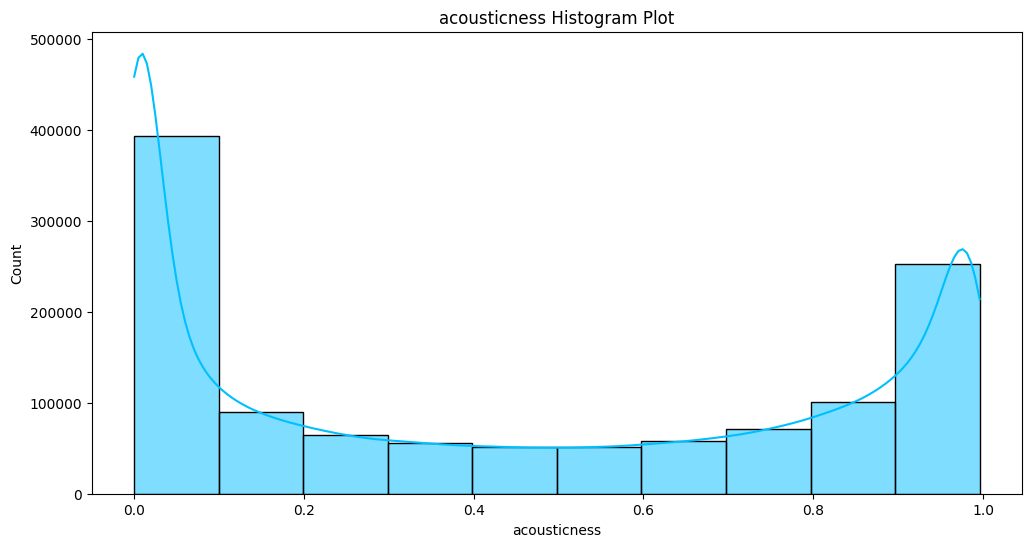

In [37]:
hist_plot(df, 'acousticness', normal_estimation=False)

### <a id='toc1_8_9_'></a>[Instrumentalness](#toc0_)

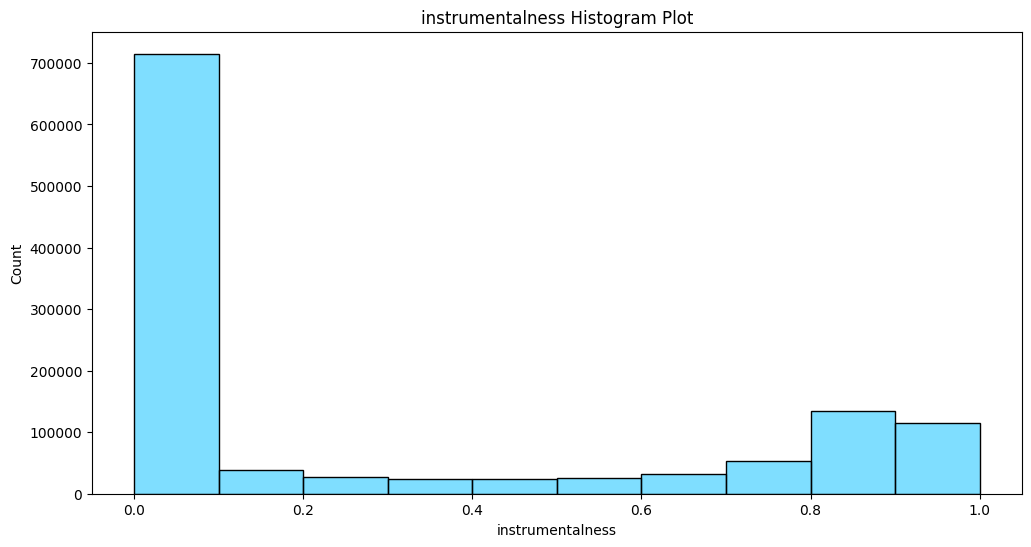

In [38]:
hist_plot(df, 'instrumentalness', kde=False, normal_estimation=False)

### <a id='toc1_8_10_'></a>[Liveness](#toc0_)

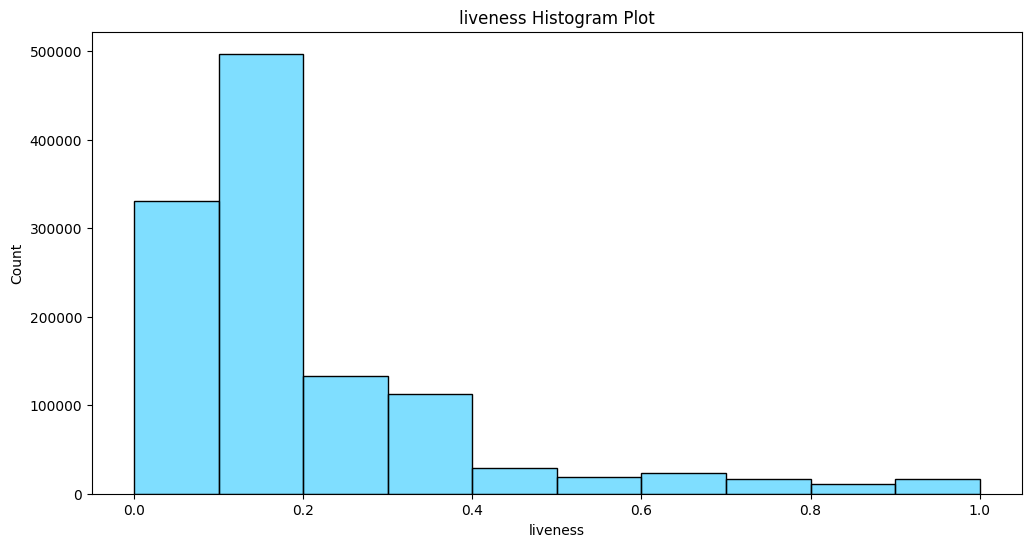

In [39]:
hist_plot(df, 'liveness', kde=False, normal_estimation=False)

### <a id='toc1_8_11_'></a>[Valence](#toc0_)

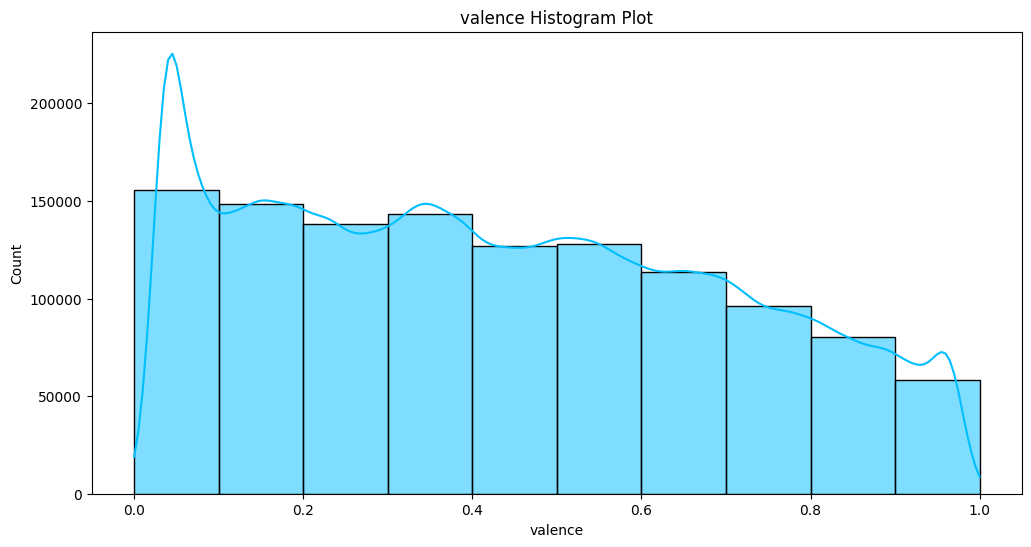

In [40]:
hist_plot(df, 'valence', normal_estimation=False)

### <a id='toc1_8_12_'></a>[Tempo](#toc0_)

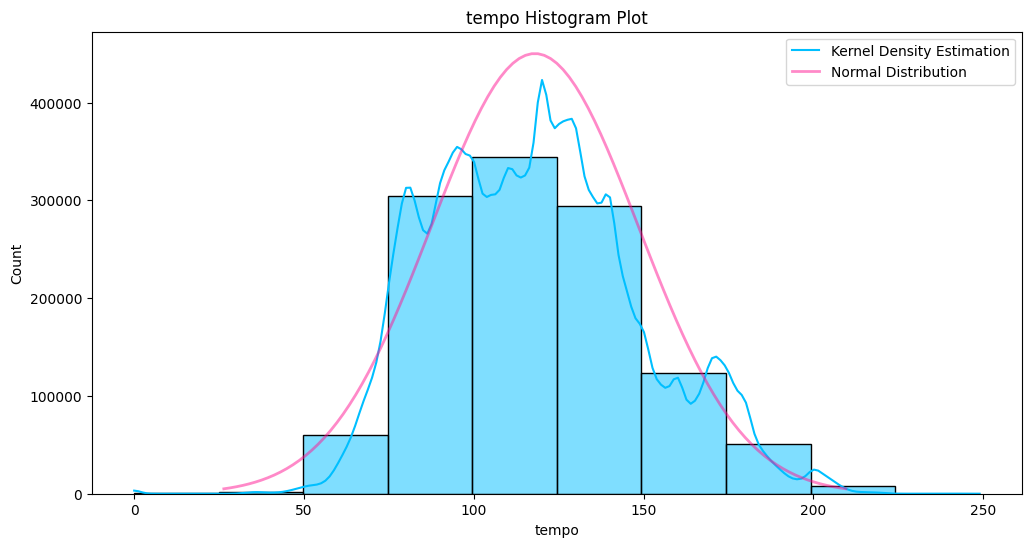

In [41]:
hist_plot(df, 'tempo')

### <a id='toc1_8_13_'></a>[Duration](#toc0_)

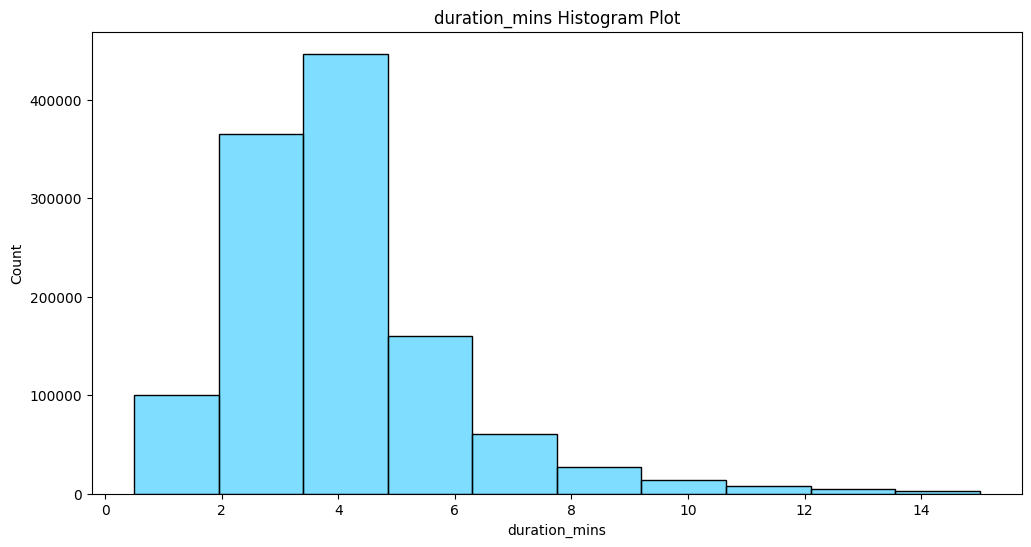

In [42]:
hist_plot(df, 'duration_mins', normal_estimation=False, kde=False)

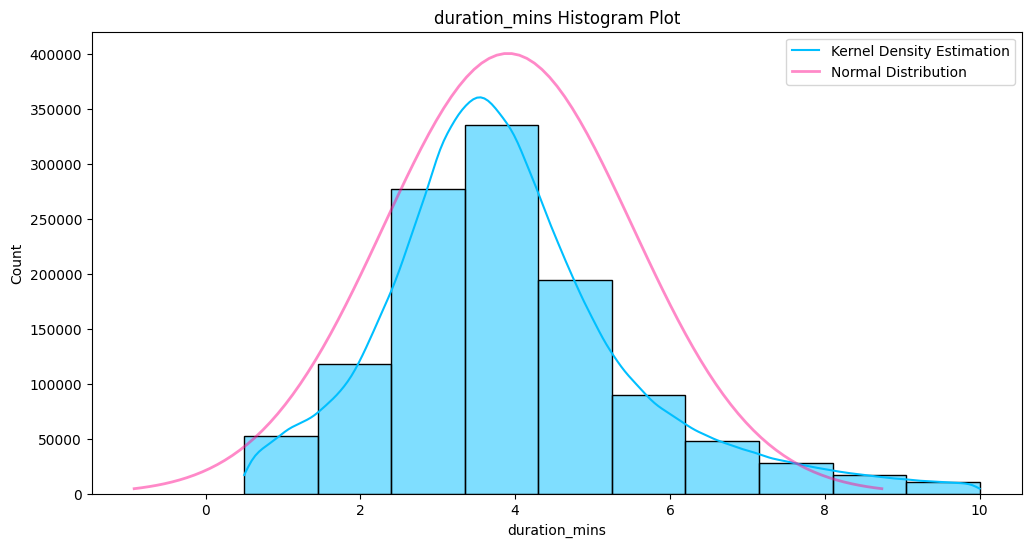

In [103]:
MAX_DURATION_MINS = 10
hist_plot(df.filter(col('duration_mins') < MAX_DURATION_MINS), 'duration_mins')

As we can see, most of the songs have a duration between 2 and 5 minutes, which is expected.

### <a id='toc1_8_14_'></a>[Time Signature](#toc0_)

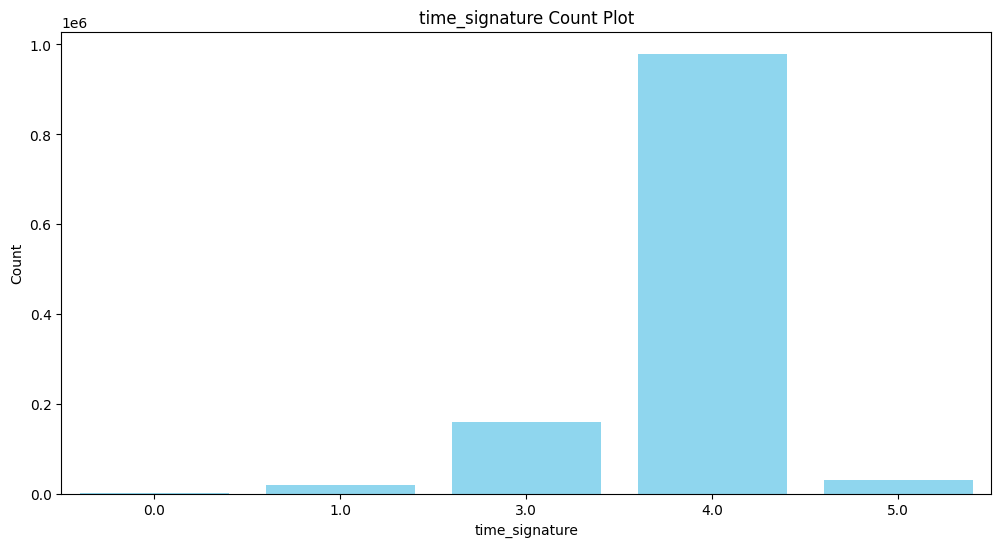

In [44]:
count_plot(df, 'time_signature', sorted=False)

As we can see, most of the songs in this dataset have time signature of 4 which is expected, because most of the songs (specially the western ones) are in 4/4 time signature.

### <a id='toc1_8_15_'></a>[Year](#toc0_)

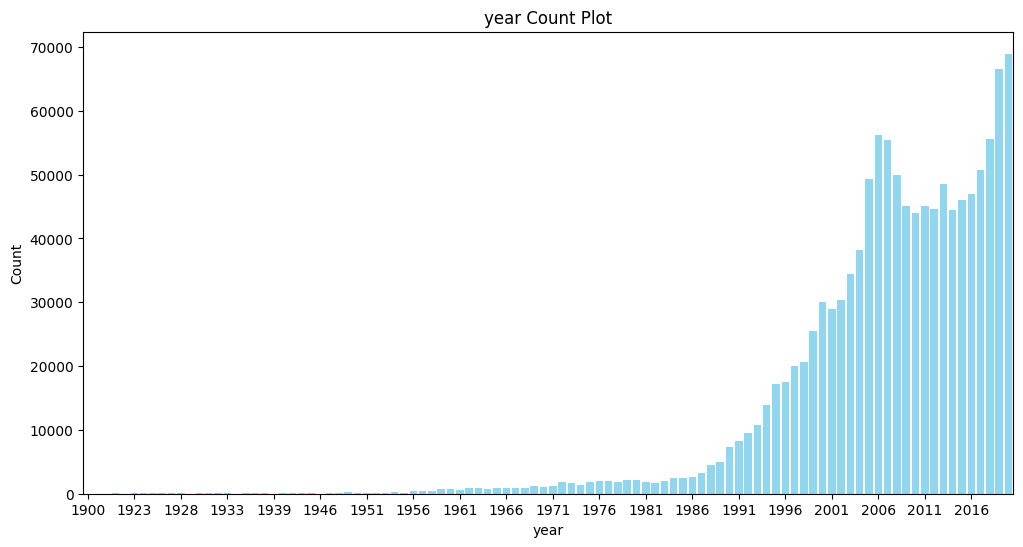

In [109]:
count_plot(df, 'year', step=5, sorted=False)

We can see the rising trend of the number of songs released over the years. This is expected because the music industry has been growing over the years.

### <a id='toc1_8_16_'></a>[Decade](#toc0_)

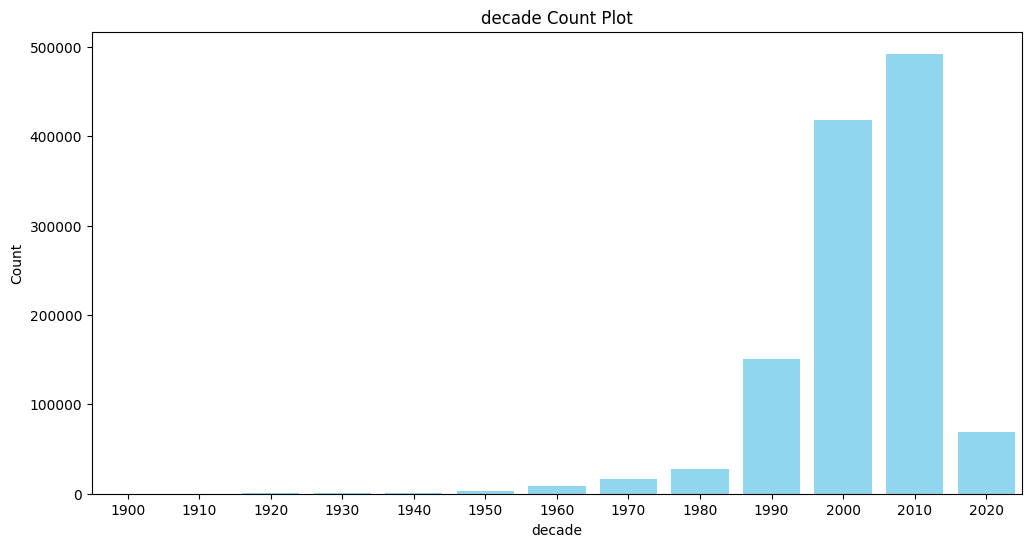

In [46]:
count_plot(df, 'decade', sorted=False)

### <a id='toc1_8_17_'></a>[Quarter](#toc0_)

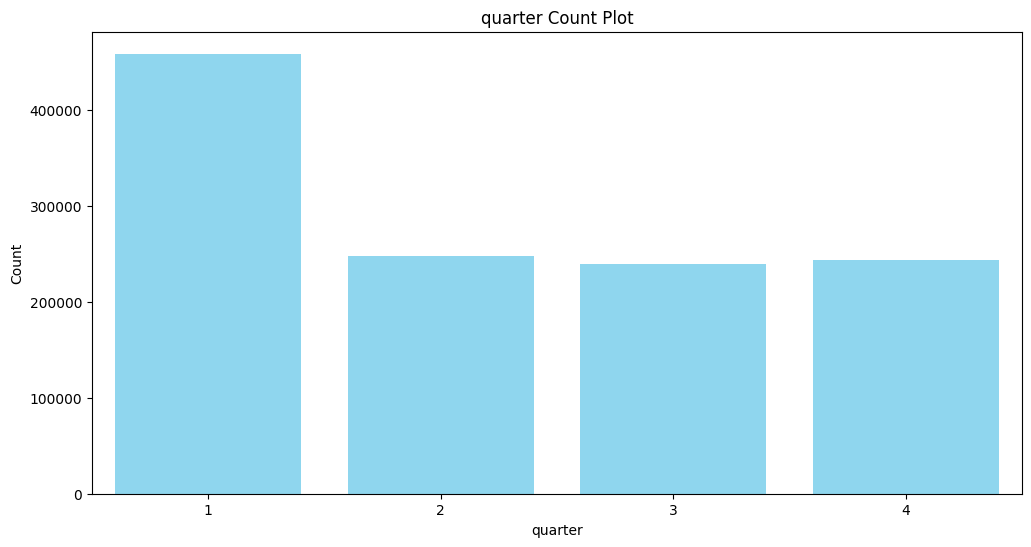

In [47]:
count_plot(df, 'quarter', sorted=False)

### <a id='toc1_8_18_'></a>[Month](#toc0_)

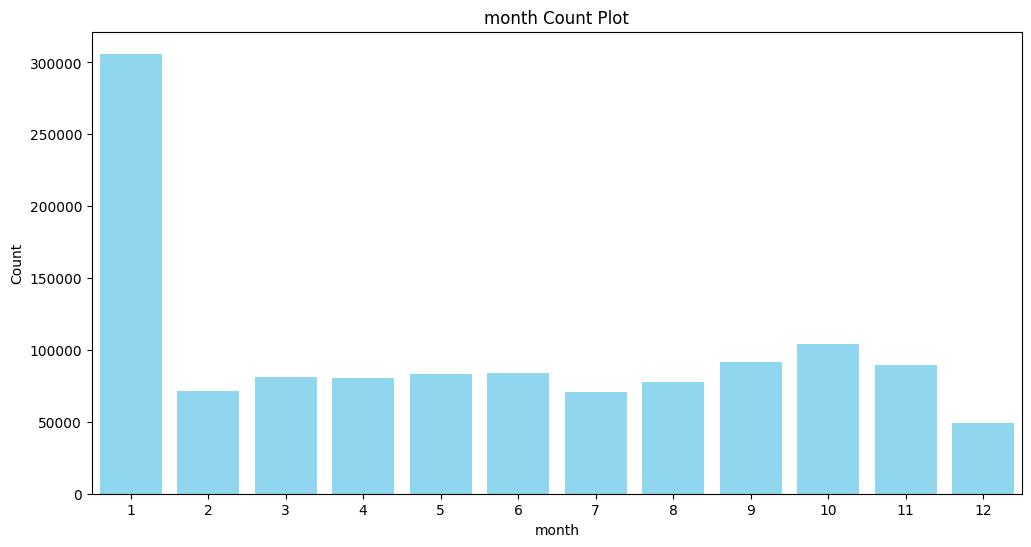

In [48]:
count_plot(df, 'month', sorted=False)

### <a id='toc1_8_19_'></a>[Week](#toc0_)

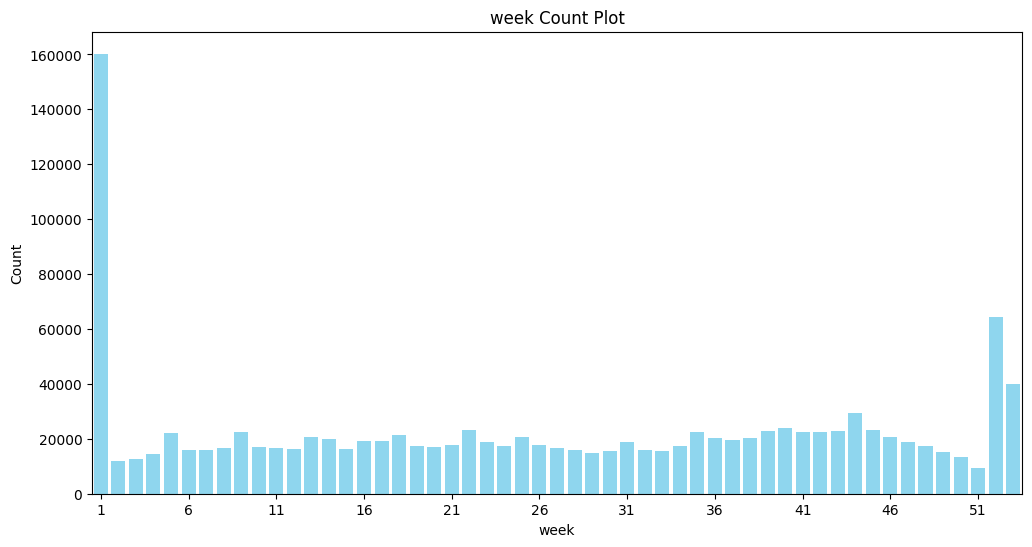

In [107]:
count_plot(df, 'week', step=5, sorted=False)

As we can see, most of the songs are released in first and last weeks of the year. One reason for this could be that the first week of the year is a popular time for new releases, and the last week of the year is a popular time for holiday music. 

Other reason for this observation is that information about a lot of tracks in this dataset (specially the older ones) could be inaccurate, for example only the release year of an old track is known and not the exact date.

### <a id='toc1_8_20_'></a>[Day](#toc0_)

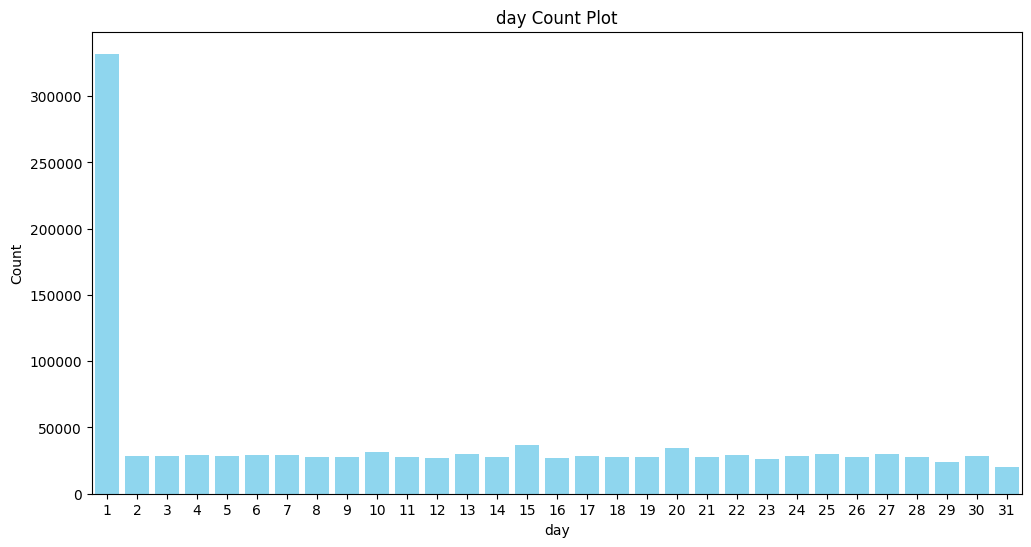

In [50]:
count_plot(df, 'day', sorted=False)

For older tracks, especially those from the 20th century, there might be less accurate or readily available information about their exact release dates. Streaming services or data providers might not have access to this information or might not have it recorded in a consistent format.

In cases where the exact release date is unknown, some data providers might assign a default value for consistency. The first day of the month (often coded as "01-01") might be a common placeholder used for these tracks.


### <a id='toc1_8_21_'></a>[Weekday](#toc0_)

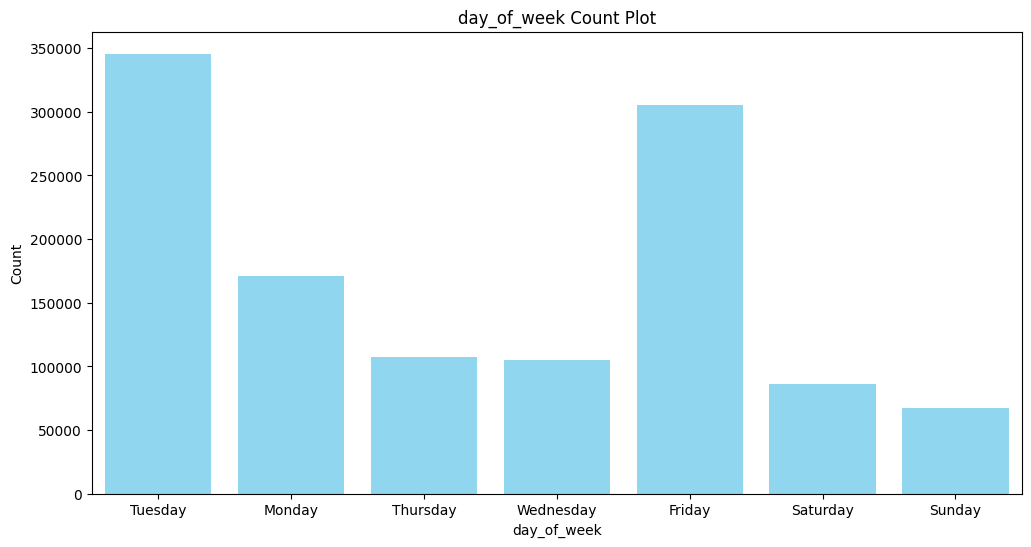

In [51]:
count_plot(df, 'day_of_week', sorted=False)

As we can see, most of the songs are released on Tuesdays and Fridays. Traditionally, Fridays were the preferred day for new music releases. Tuesdays might serve as a secondary release day to avoid competing with the established "New Music Friday" trend.

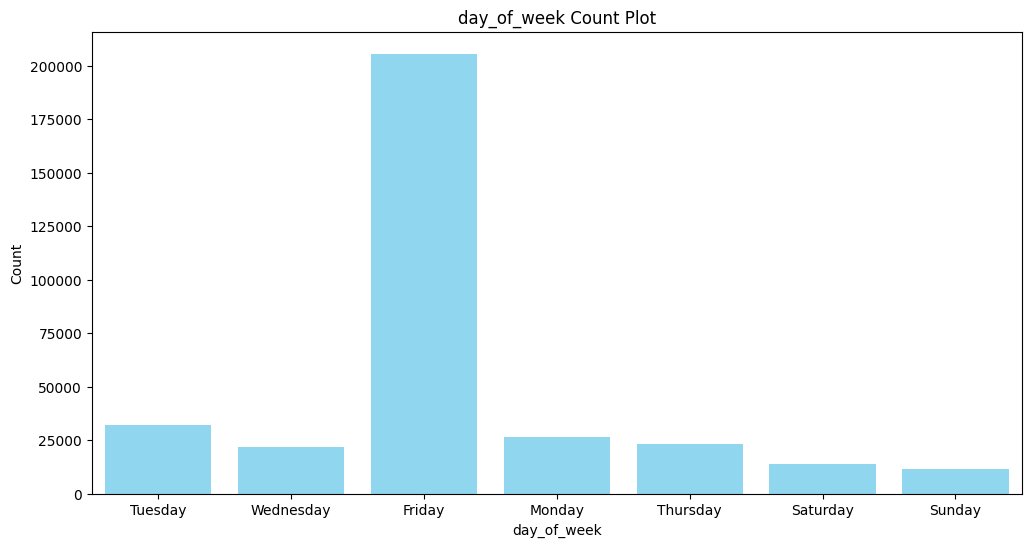

In [52]:
SINCE = 2014
count_plot(df.filter(col('year') > SINCE), 'day_of_week', sorted=False)

As we can see, nowadays most of the songs are released on Fridays. This is because Friday is the most popular day for new music releases. Artists and record labels often release new music on Fridays to take advantage of the weekend, when people have more time to listen to music.

## <a id='toc1_9_'></a>[Top Records](#toc0_)

In [53]:
TOP_RECORDS_COUNT = 5
TOP_RECORDS_COUNT_FOR_PLOTS = 10

### <a id='toc1_9_1_'></a>[The Most Danceable Songs](#toc0_)

In [54]:
show(df.orderBy('danceability', ascending=False), n=TOP_RECORDS_COUNT)

Number of rows: 1188345


+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------------------+---+--------+----+-----------+------------+--------------------+------------------+-------+-------+-----------+--------------+----+------------+-----+---+-----------+----+-------+-----------+------+------------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|danceability|            energy|key|loudness|mode|speechiness|acousticness|    instrumentalness|          liveness|valence|  tempo|duration_ms|time_signature|year|release_date|month|day|day_of_week|week|quarter|day_of_year|decade|     duration_mins|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+----

### <a id='toc1_9_2_'></a>[The Most Valence Songs](#toc0_)

In [55]:
show(df.orderBy('valence', ascending=False), n=TOP_RECORDS_COUNT)

Number of rows: 1188345


+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------------------+---+-------------------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----+------------+-----+---+-----------+----+-------+-----------+------+------------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|      danceability|            energy|key|           loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|time_signature|year|release_date|month|day|day_of_week|week|quarter|day_of_year|decade|     duration_mins|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+-----------

### <a id='toc1_9_3_'></a>[The Least Valence Songs](#toc0_)

In [56]:
show(df.orderBy('valence', ascending=True), n=TOP_RECORDS_COUNT)

Number of rows: 1188345


+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+------------+-----------+--------+------------+-------+---+-------------------+----+-----------+------------+----------------+------------------+-------+------------------+-----------+--------------+----+------------+-----+---+-----------+----+-------+-----------+------+------------------+
|                  id|                name|               album|            album_id|            artists|          artist_ids|track_number|disc_number|explicit|danceability| energy|key|           loudness|mode|speechiness|acousticness|instrumentalness|          liveness|valence|             tempo|duration_ms|time_signature|year|release_date|month|day|day_of_week|week|quarter|day_of_year|decade|     duration_mins|
+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+------------+-----------+--------+------

### <a id='toc1_9_4_'></a>[The Most Energetic Songs](#toc0_)

In [57]:
show(df.orderBy('energy', ascending=False), n=TOP_RECORDS_COUNT)

Number of rows: 1188345


+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+------------+-----------+--------+------------------+------+---+-------------------+----+-----------+------------------+------------------+--------+------------------+-------+-----------+--------------+----+------------+-----+---+-----------+----+-------+-----------+------+------------------+
|                  id|                name|               album|            album_id|            artists|          artist_ids|track_number|disc_number|explicit|      danceability|energy|key|           loudness|mode|speechiness|      acousticness|  instrumentalness|liveness|           valence|  tempo|duration_ms|time_signature|year|release_date|month|day|day_of_week|week|quarter|day_of_year|decade|     duration_mins|
+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+------------+-----------+--------+

### <a id='toc1_9_5_'></a>[The Loudest Songs](#toc0_)

In [58]:
show(df.orderBy('loudness', ascending=False), n=TOP_RECORDS_COUNT)

Number of rows: 1188345


+--------------------+--------------------+------+--------------------+----------------+--------------------+------------+-----------+--------+------------+-------+---+------------------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----+------------+-----+---+-----------+----+-------+-----------+------+------------------+
|                  id|                name| album|            album_id|         artists|          artist_ids|track_number|disc_number|explicit|danceability| energy|key|          loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|time_signature|year|release_date|month|day|day_of_week|week|quarter|day_of_year|decade|     duration_mins|
+--------------------+--------------------+------+--------------------+----------------+--------------------+------------+-----------+--------+------------+-------+---+------------------+----+-----------+------------+----------------+--------+-

### <a id='toc1_9_6_'></a>[The Quietest Songs](#toc0_)

In [59]:
show(df.orderBy('loudness', ascending=True), n=TOP_RECORDS_COUNT)

Number of rows: 1188345


+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-----+-----------+--------------+----+------------+-----+---+-----------+----+-------+-----------+------+------------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|tempo|duration_ms|time_signature|year|release_date|month|day|day_of_week|week|quarter|day_of_year|decade|     duration_mins|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+----------

### <a id='toc1_9_7_'></a>[The Longest Songs](#toc0_)

In [60]:
show(df.orderBy('duration_ms', ascending=False), n=TOP_RECORDS_COUNT)

Number of rows: 1188345


+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+-------+---+--------+----+-----------+------------+----------------+--------+-------+-------+-----------+--------------+----+------------+-----+---+-----------+----+-------+-----------+------+-------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|danceability| energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|duration_ms|time_signature|year|release_date|month|day|day_of_week|week|quarter|day_of_year|decade|duration_mins|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+-------+---+--------+----+-----------+------------+-------------

### <a id='toc1_9_8_'></a>[The Shortest Songs](#toc0_)

In [61]:
show(df.orderBy('duration_ms', ascending=True), n=TOP_RECORDS_COUNT)

Number of rows: 1188345


+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+------------------+--------+-------+-------+-----------+--------------+----+------------+-----+---+-----------+----+-------+-----------+------+-------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|danceability|energy|key|loudness|mode|speechiness|acousticness|  instrumentalness|liveness|valence|  tempo|duration_ms|time_signature|year|release_date|month|day|day_of_week|week|quarter|day_of_year|decade|duration_mins|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+------+---+--------+----+-----------+------------+------------

### <a id='toc1_9_9_'></a>[Songs with the Highest Tempo](#toc0_)

In [62]:
show(df.orderBy('tempo', ascending=False), n=TOP_RECORDS_COUNT)

Number of rows: 1188345


+--------------------+--------------------+--------------------+--------------------+------------------+--------------------+------------+-----------+--------+------------------+------------------+---+------------------+----+-----------+------------------+------------------+------------------+------------------+------------------+-----------+--------------+----+------------+-----+---+-----------+----+-------+-----------+------+------------------+
|                  id|                name|               album|            album_id|           artists|          artist_ids|track_number|disc_number|explicit|      danceability|            energy|key|          loudness|mode|speechiness|      acousticness|  instrumentalness|          liveness|           valence|             tempo|duration_ms|time_signature|year|release_date|month|day|day_of_week|week|quarter|day_of_year|decade|     duration_mins|
+--------------------+--------------------+--------------------+--------------------+-------------

### <a id='toc1_9_10_'></a>[Songs with the Lowest Tempo](#toc0_)

In [63]:
show(df.orderBy('tempo', ascending=True), n=TOP_RECORDS_COUNT)

Number of rows: 1188345


+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+-------+---+--------+----+-----------+------------+----------------+------------------+-------+-----+-----------+--------------+----+------------+-----+---+-----------+----+-------+-----------+------+------------------+
|                  id|                name|               album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|danceability| energy|key|loudness|mode|speechiness|acousticness|instrumentalness|          liveness|valence|tempo|duration_ms|time_signature|year|release_date|month|day|day_of_week|week|quarter|day_of_year|decade|     duration_mins|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------+-------+---+--------+----+-----------+

### <a id='toc1_9_11_'></a>[The Oldest Songs](#toc0_)

In [64]:
show(df.orderBy('year', ascending=True), n=TOP_RECORDS_COUNT)

Number of rows: 1188345


+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+------------+-----------+--------+------------------+------------------+---+--------+----+-----------+------------------+------------------+------------------+------------------+-------+-----------+--------------+----+------------+-----+---+-----------+----+-------+-----------+------+------------------+
|                  id|                name|        album|            album_id|             artists|          artist_ids|track_number|disc_number|explicit|      danceability|            energy|key|loudness|mode|speechiness|      acousticness|  instrumentalness|          liveness|           valence|  tempo|duration_ms|time_signature|year|release_date|month|day|day_of_week|week|quarter|day_of_year|decade|     duration_mins|
+--------------------+--------------------+-------------+--------------------+--------------------+--------------------+------------+-----------+-----

### <a id='toc1_9_12_'></a>[Artists with the Most Songs](#toc0_)

In [110]:
def show_barplot(df, x, y, figsize=(12, 6), xlabel=None, ylabel=None, title=None, step=None):
	
	if xlabel is None:
		xlabel = x
	if ylabel is None:
		ylabel = y
	if title is None:
		title = f'{y} by {x} Bar Plot'

	plt.figure(figsize=figsize)
	sns.barplot(data=df.toPandas(), x=x, y=y, color='deepskyblue', alpha=0.5)
	plt.xlabel(xlabel)
	plt.ylabel(ylabel)
	plt.title(title)
	if step is not None:
		plt.xticks = plt.xticks()[0][::step]
	plt.show()
          

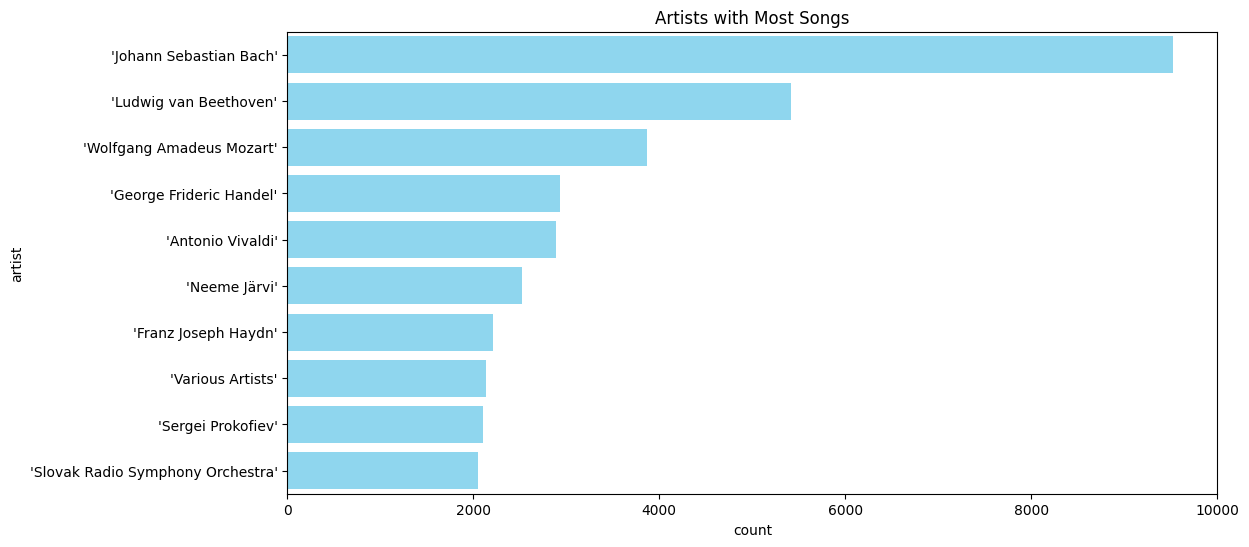

In [88]:
artists_song_count = df.select('artists').withColumn('artist', explode(col('artists'))).groupBy('artist').count()
artists_with_most_songs = artists_song_count.orderBy('count', ascending=False).limit(TOP_RECORDS_COUNT_FOR_PLOTS)
show_barplot(artists_with_most_songs, 'count', 'artist', title='Artists with Most Songs')

### <a id='toc1_9_13_'></a>[Artists with the Most Albums](#toc0_)

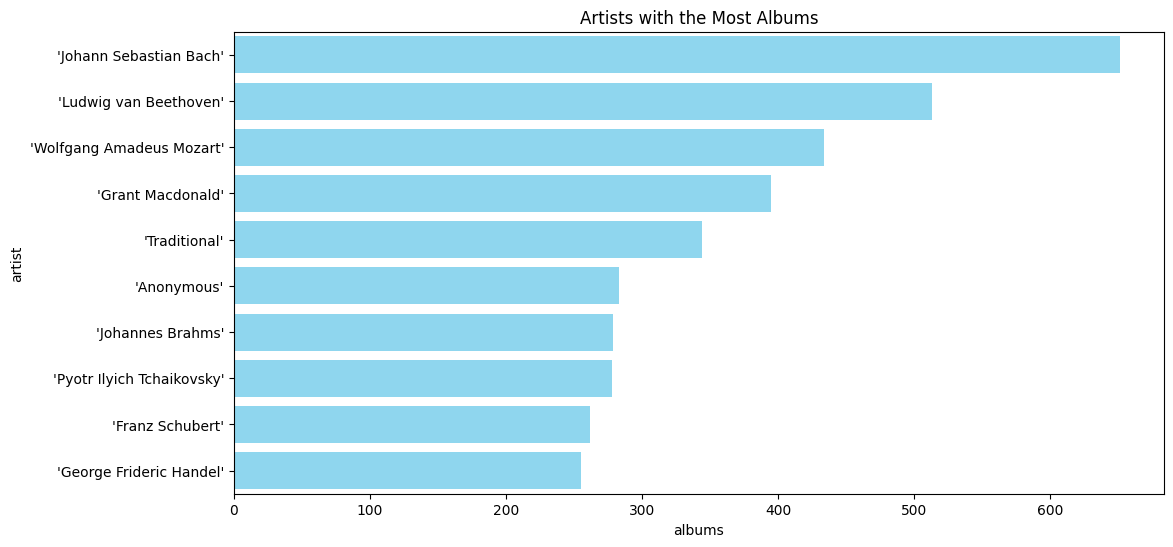

In [71]:
artist_album_count = df.select('artists', 'album').withColumn('artist', explode(col('artists'))).groupBy('artist').agg(countDistinct('album').alias('albums'))
artists_with_most_albums = artist_album_count.orderBy('albums', ascending=False).limit(TOP_RECORDS_COUNT_FOR_PLOTS)
show_barplot(artists_with_most_albums, 'albums', 'artist', title='Artists with the Most Albums')

### <a id='toc1_9_14_'></a>[Albums with the Most Songs](#toc0_)


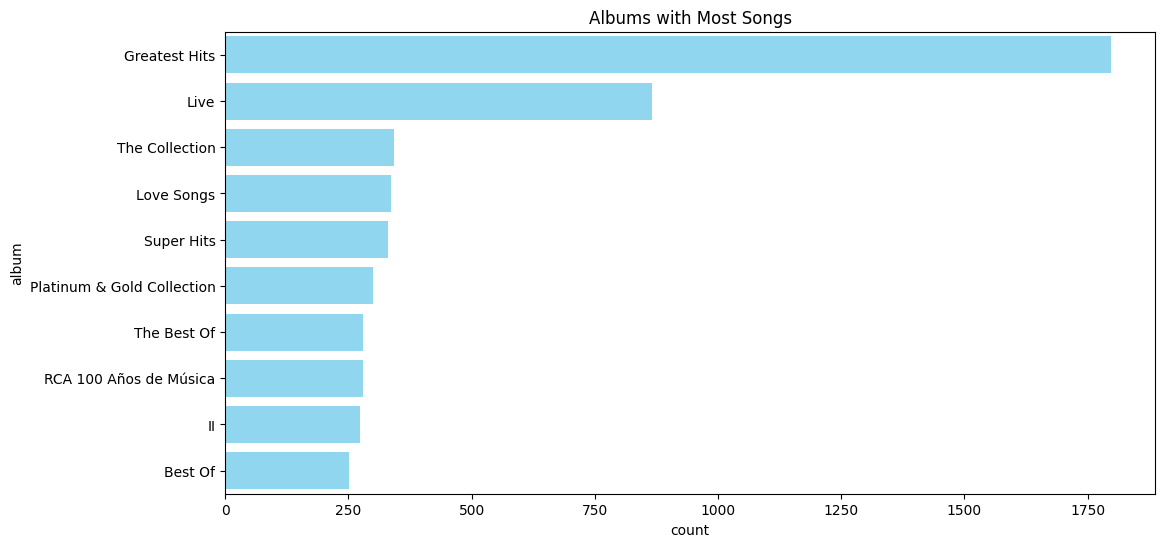

In [72]:
albums_with_most_songs = df.groupBy('album').count().orderBy('count', ascending=False).limit(TOP_RECORDS_COUNT_FOR_PLOTS)
show_barplot(albums_with_most_songs, 'count', 'album', title='Albums with Most Songs')

### <a id='toc1_9_15_'></a>[Albums with the Most Artists](#toc0_)

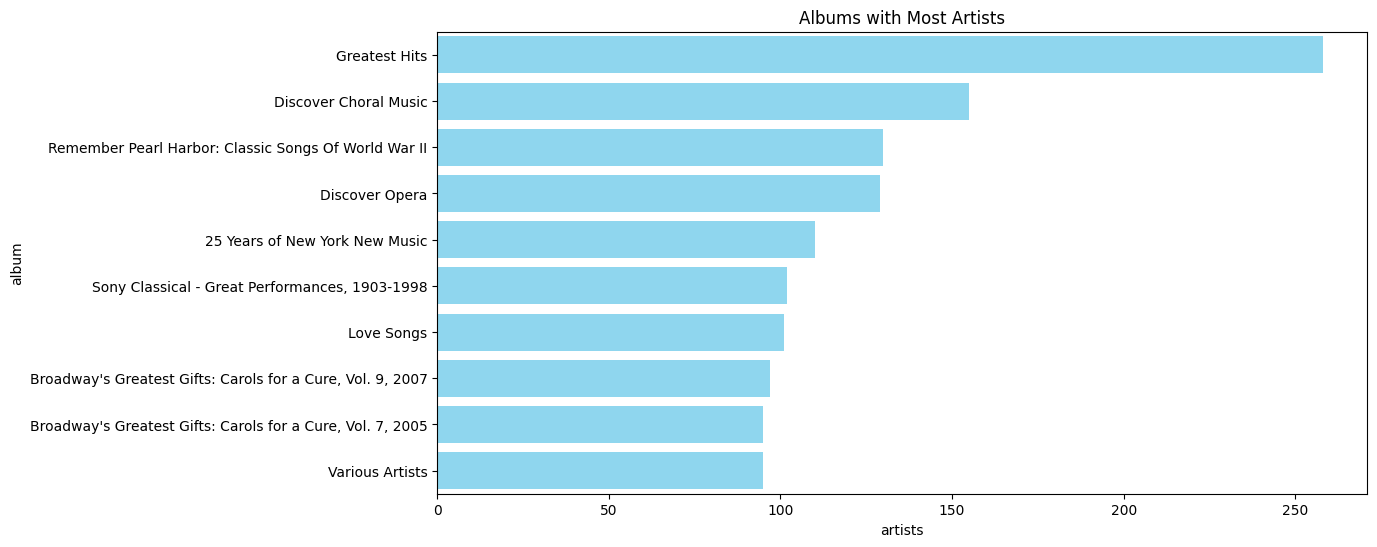

In [73]:
albums_with_most_artists = df.select('album', 'artists').withColumn('artist', explode(col('artists'))).groupBy('album').agg(countDistinct('artist').alias('artists')).orderBy('artists', ascending=False).limit(TOP_RECORDS_COUNT_FOR_PLOTS)
show_barplot(albums_with_most_artists, 'artists', 'album', title='Albums with Most Artists')

### <a id='toc1_9_16_'></a>[Artists with the Most Explicit Songs](#toc0_)

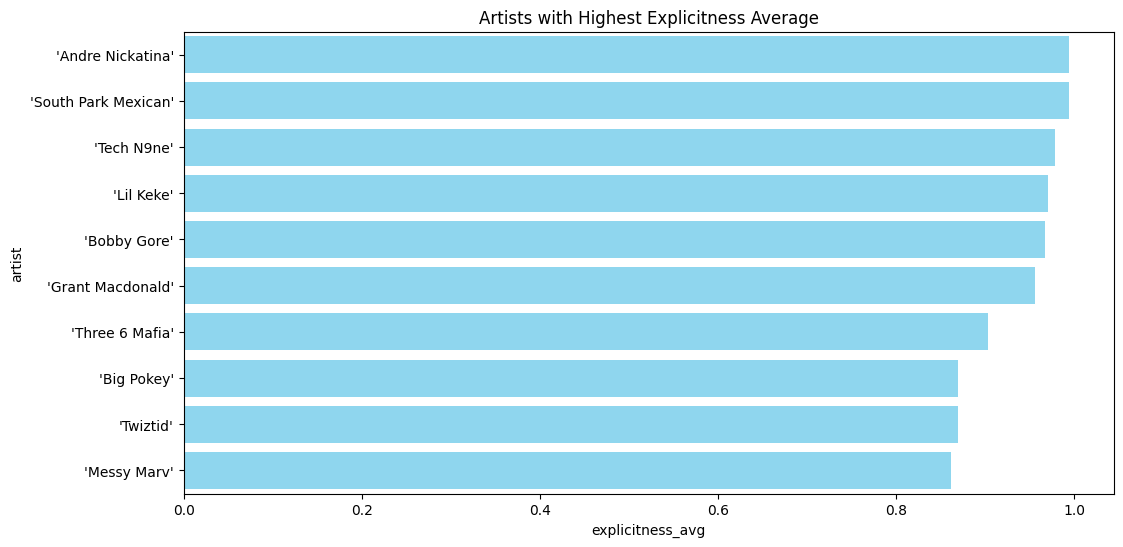

In [95]:
MIN_SONGS_COUNT = 150
filtered_artists = artists_song_count.filter(col('count') >= MIN_SONGS_COUNT)
artists_explicitness_avg = df.withColumn('artist', explode(col('artists'))) \
    .groupBy('artist') \
    .agg(avg(when(col('explicit') == 'true', 1.0).otherwise(0.0)).alias('explicitness_avg'))
artists_explicitness_avg = artists_explicitness_avg.join(filtered_artists, 'artist')
most_explicit_artists = artists_explicitness_avg.orderBy('explicitness_avg', ascending=False).limit(TOP_RECORDS_COUNT_FOR_PLOTS)
show_barplot(most_explicit_artists, 'explicitness_avg', 'artist', title='Artists with Highest Explicitness Average')

### <a id='toc1_9_17_'></a>[Artists with the Most Danceable Songs](#toc0_)

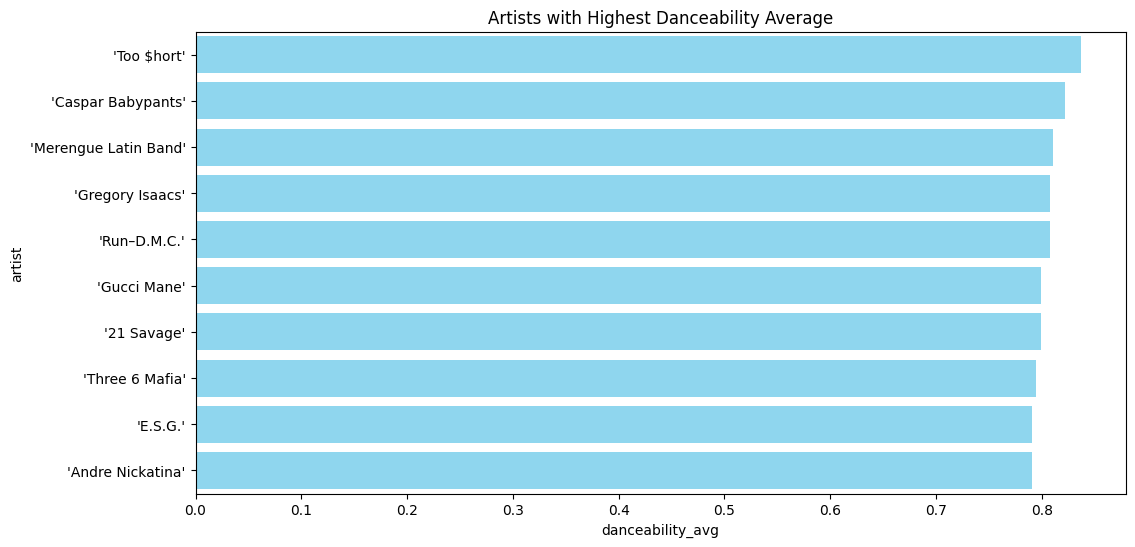

In [99]:
MIN_SONGS_COUNT = 10
artists_danceability_avg = df.withColumn('artist', explode(col('artists'))) \
	.groupBy('artist') \
	.agg(avg(col('danceability')).alias('danceability_avg'))
artists_danceability_avg = artists_danceability_avg.join(filtered_artists, 'artist')
most_danceable_artists = artists_danceability_avg.orderBy('danceability_avg', ascending=False).limit(TOP_RECORDS_COUNT_FOR_PLOTS)
show_barplot(most_danceable_artists, 'danceability_avg', 'artist', title='Artists with Highest Danceability Average')


### <a id='toc1_9_18_'></a>[Artists with the Loudest Songs](#toc0_)

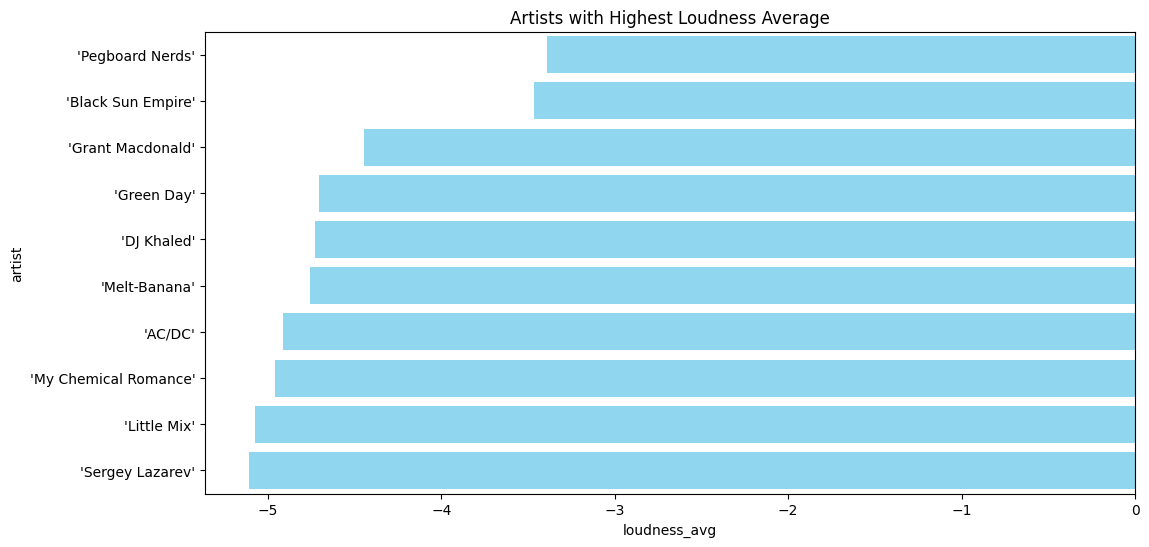

In [101]:
MIN_SONGS_COUNT = 10
artists_loudness_avg = df.withColumn('artist', explode(col('artists'))) \
	.groupBy('artist') \
	.agg(avg(col('loudness')).alias('loudness_avg'))
artists_loudness_avg = artists_loudness_avg.join(filtered_artists, 'artist')
most_loud_artists = artists_loudness_avg.orderBy('loudness_avg', ascending=False).limit(TOP_RECORDS_COUNT_FOR_PLOTS)
show_barplot(most_loud_artists, 'loudness_avg', 'artist', title='Artists with Highest Loudness Average')

## <a id='toc1_10_'></a>[Trends Over Time](#toc0_)

In this section, we will analyze how the features of the songs have changed over time. We will look at the average values of the features for each year and decade.

WWII impact
An intresting point to consider in the following plots is the impact of WWII on the music industry. As we can see, the number of songs released in the 1940s is significantly lower than the other decades. This is expected because the music industry was heavily impacted by WWII (1939-1945). Many artists were conscripted into the military, and the production of records and musical instruments was severely limited. As a result, there were fewer new releases during this time period.

Also by seeing the danceabilty, valence, and tempo trends, we can see that during WWII this features face a significant drop.

We can see that the average energy of songs has been increasing over the years. This is expected because music has become more energetic and upbeat over time. 

Acousticness has been decreasing over the years. This is expected because music has become less acoustic and more electronic over time.

Another intresting point here is the huge rise of explicit songs in the last decade. This is expected because of the modern genres like rap and hip-hop which are more likely to contain explicit content.

In [117]:
def line_plot(df, x, y_list, figsize=(12, 6), xlabel=None, ylabel=None, title=None, step=None):
	if xlabel is None:
		xlabel = x
	if ylabel is None:
		ylabel = ', '.join(y_list)
	if title is None:
		title = f'{ylabel} by {x} Line Plot'

	plt.figure(figsize=figsize)
	for y in y_list:
		sns.lineplot(data=df.toPandas(), x=x, y=y, label=y)
	plt.xlabel(xlabel)
	plt.ylabel(ylabel)
	plt.title(title)
	if step is not None:
		plt.xticks = plt.xticks()[0][::step]
	plt.show()

### <a id='toc1_10_1_'></a>[Features Average Trends over Time](#toc0_)

In [126]:
average_danceability_by_year = df.groupBy('year').agg(avg(col('danceability')).alias('danceability_avg')).orderBy('year')
average_energy_by_year = df.groupBy('year').agg(avg(col('energy')).alias('energy_avg')).orderBy('year')
average_valence_by_year = df.groupBy('year').agg(avg(col('valence')).alias('valence_avg')).orderBy('year')
average_loudness_by_year = df.groupBy('year').agg(avg(col('loudness')).alias('loudness_avg')).orderBy('year')
average_tempo_by_year = df.groupBy('year').agg(avg(col('tempo')).alias('tempo_avg')).orderBy('year')
average_duration_by_year = df.groupBy('year').agg(avg(col('duration_mins')).alias('duration_avg')).orderBy('year')
average_explicitness_by_year = df.groupBy('year').agg(avg(when(col('explicit') == 'true', 1.0).otherwise(0.0)).alias('explicitness_avg')).orderBy('year')
average_speechiness_by_year = df.groupBy('year').agg(avg(col('speechiness')).alias('speechiness_avg')).orderBy('year')
average_acousticness_by_year = df.groupBy('year').agg(avg(col('acousticness')).alias('acousticness_avg')).orderBy('year')

In [127]:
average_features_by_year = average_danceability_by_year.join(average_energy_by_year, 'year') \
	.join(average_valence_by_year, 'year') \
	.join(average_loudness_by_year, 'year') \
	.join(average_tempo_by_year, 'year') \
	.join(average_duration_by_year, 'year') \
	.join(average_explicitness_by_year, 'year') \
	.join(average_speechiness_by_year, 'year') \
	.join(average_acousticness_by_year, 'year')

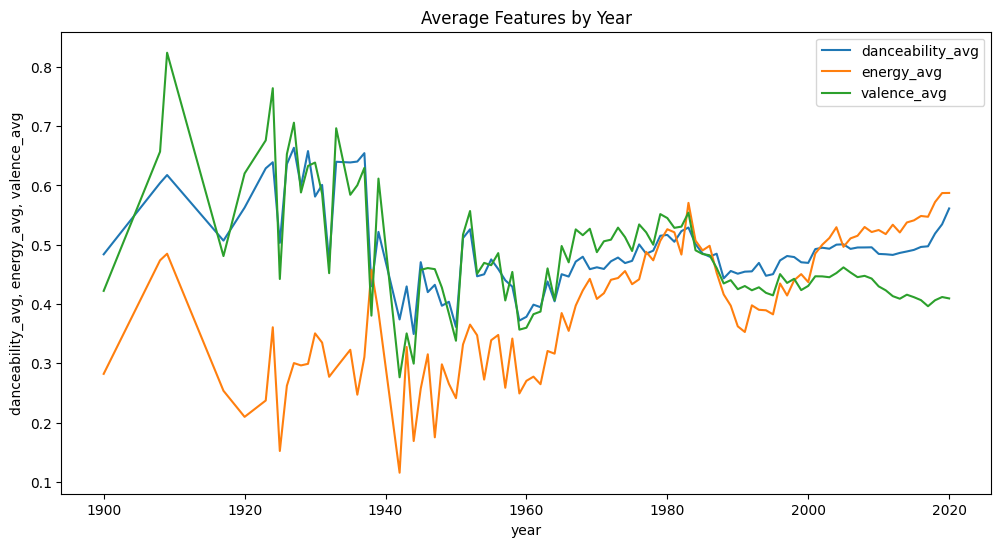

In [128]:
line_plot(average_features_by_year, 'year', ['danceability_avg', 'energy_avg', 'valence_avg'], title='Average Features by Year')

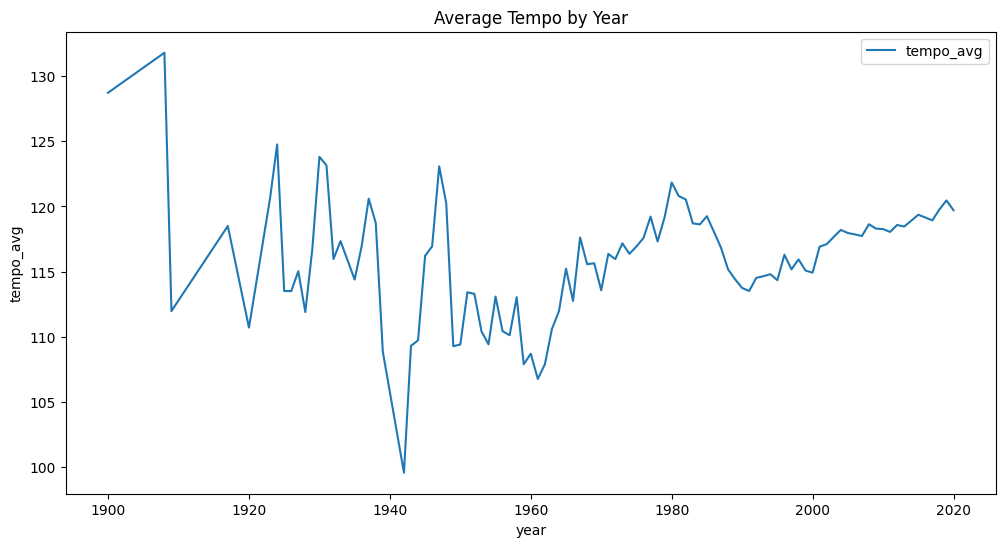

In [131]:
line_plot(average_features_by_year, 'year', ['tempo_avg'], title='Average Tempo by Year')

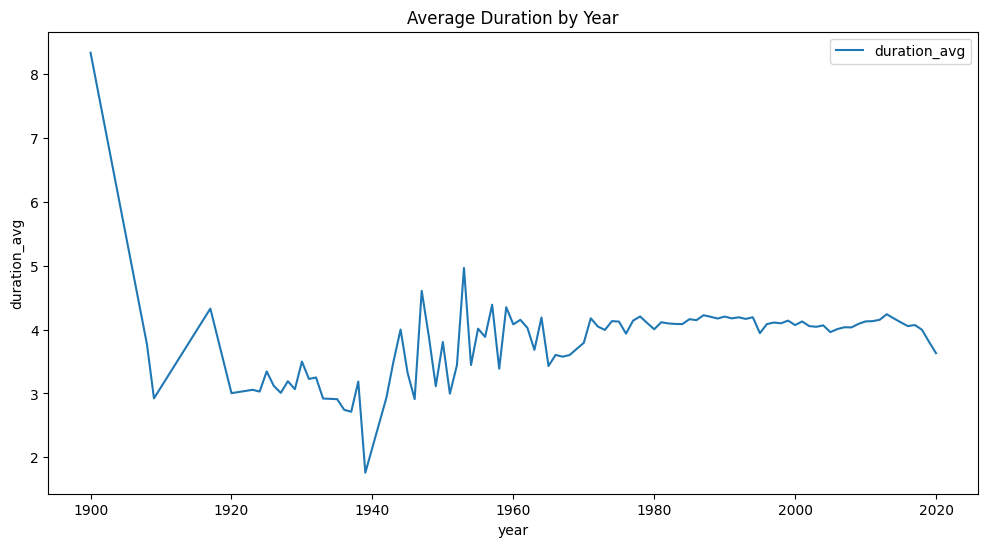

In [133]:
line_plot(average_features_by_year, 'year', ['duration_avg'], title='Average Duration by Year')

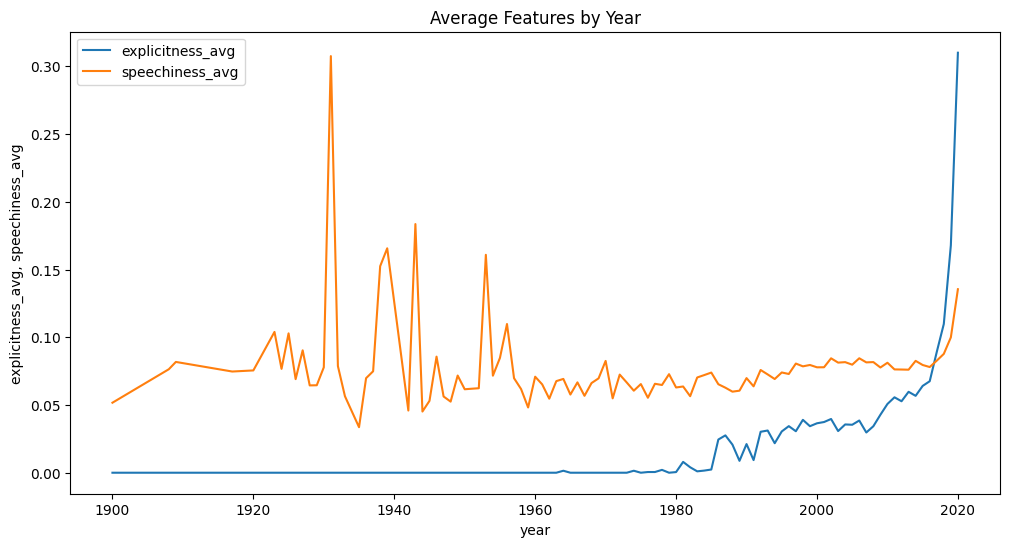

In [135]:
line_plot(average_features_by_year, 'year', ['explicitness_avg', 'speechiness_avg'], title='Average Features by Year')

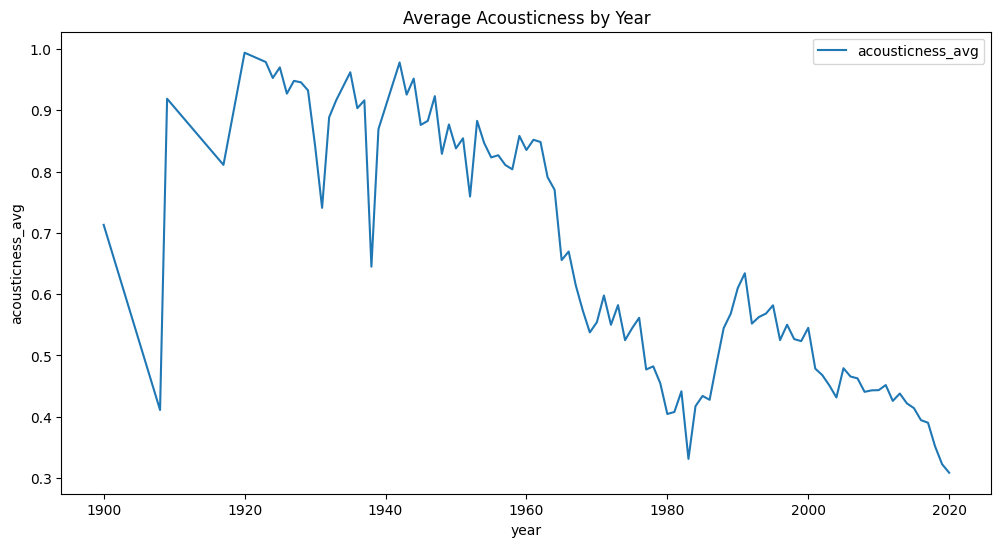

In [136]:
line_plot(average_features_by_year, 'year', ['acousticness_avg'], title='Average Acousticness by Year')

### <a id='toc1_10_2_'></a>[Average of Feature Over Decades](#toc0_)

In [137]:
average_danceability_by_decade = df.groupBy('decade').agg(avg(col('danceability')).alias('danceability_avg')).orderBy('decade')
average_energy_by_decade = df.groupBy('decade').agg(avg(col('energy')).alias('energy_avg')).orderBy('decade')
average_valence_by_decade = df.groupBy('decade').agg(avg(col('valence')).alias('valence_avg')).orderBy('decade')
average_loudness_by_decade = df.groupBy('decade').agg(avg(col('loudness')).alias('loudness_avg')).orderBy('decade')
average_tempo_by_decade = df.groupBy('decade').agg(avg(col('tempo')).alias('tempo_avg')).orderBy('decade')
average_duration_by_decade = df.groupBy('decade').agg(avg(col('duration_mins')).alias('duration_avg')).orderBy('decade')
average_explicitness_by_decade = df.groupBy('decade').agg(avg(when(col('explicit') == 'true', 1.0).otherwise(0.0)).alias('explicitness_avg')).orderBy('decade')
average_speechiness_by_decade = df.groupBy('decade').agg(avg(col('speechiness')).alias('speechiness_avg')).orderBy('decade')
average_acousticness_by_decade = df.groupBy('decade').agg(avg(col('acousticness')).alias('acousticness_avg')).orderBy('decade')

In [138]:
average_features_by_decade = average_danceability_by_decade.join(average_energy_by_decade, 'decade') \
	.join(average_valence_by_decade, 'decade') \
	.join(average_loudness_by_decade, 'decade') \
	.join(average_tempo_by_decade, 'decade') \
	.join(average_duration_by_decade, 'decade') \
	.join(average_explicitness_by_decade, 'decade') \
	.join(average_speechiness_by_decade, 'decade') \
	.join(average_acousticness_by_decade, 'decade')


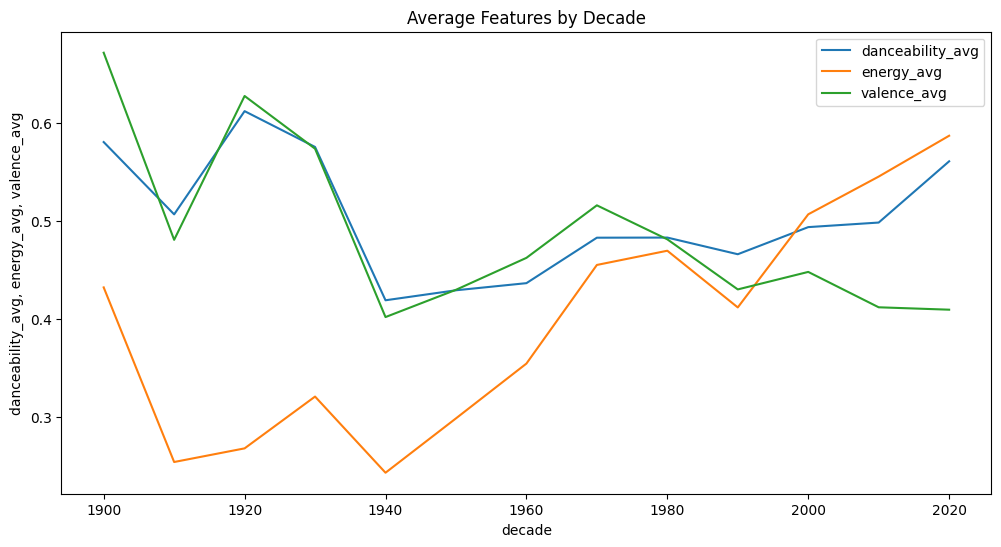

In [139]:
line_plot(average_features_by_decade, 'decade', ['danceability_avg', 'energy_avg', 'valence_avg'], title='Average Features by Decade')

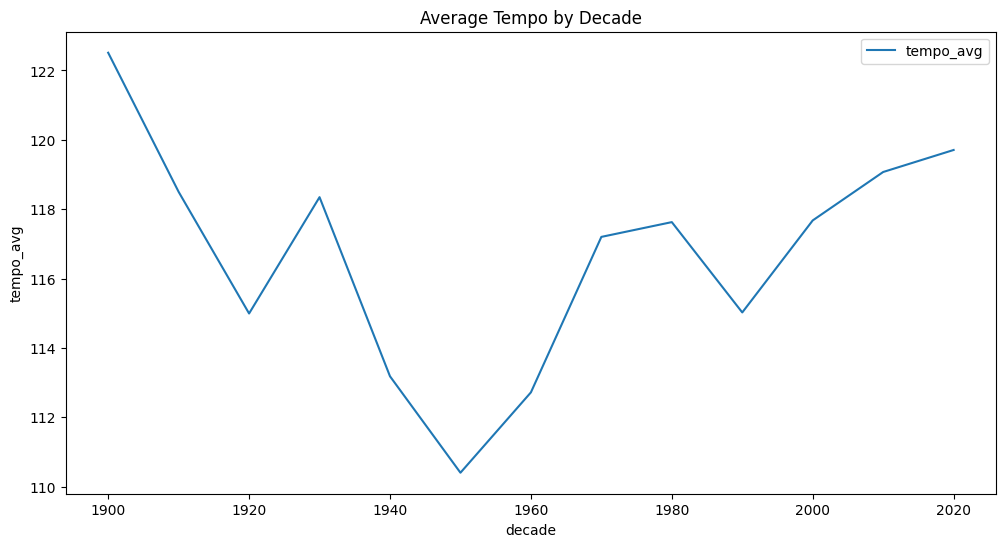

In [140]:
line_plot(average_features_by_decade, 'decade', ['tempo_avg'], title='Average Tempo by Decade')

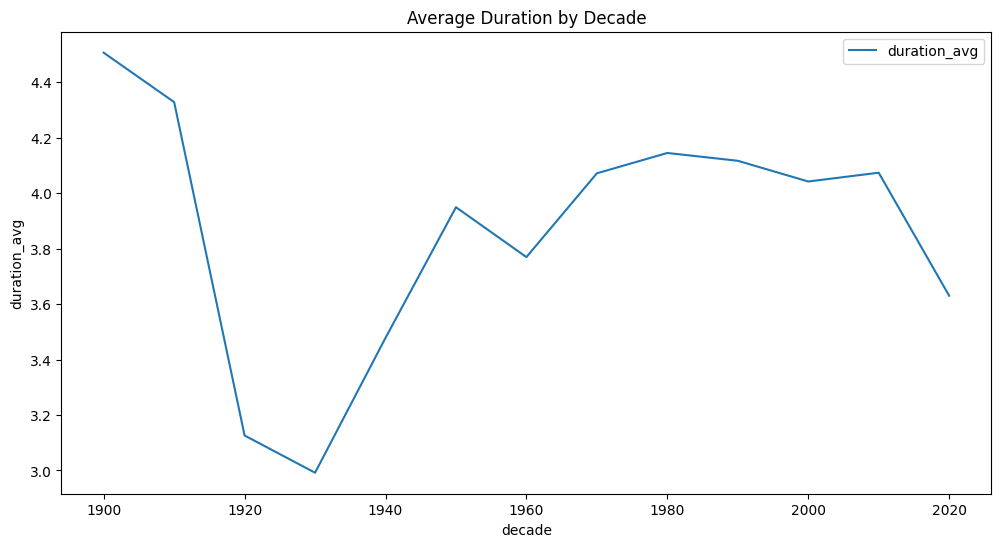

In [141]:
line_plot(average_features_by_decade, 'decade', ['duration_avg'], title='Average Duration by Decade')

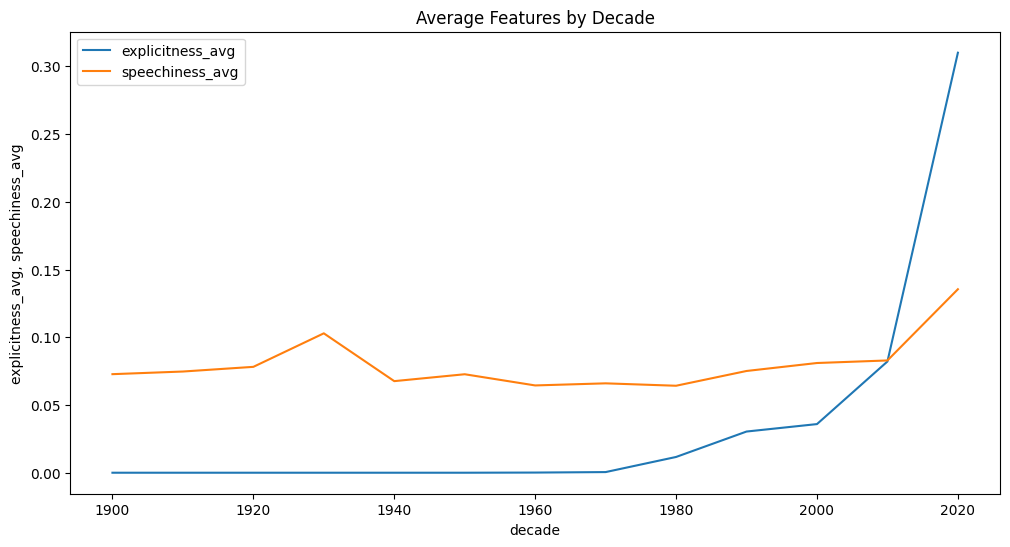

In [142]:
line_plot(average_features_by_decade, 'decade', ['explicitness_avg', 'speechiness_avg'], title='Average Features by Decade')

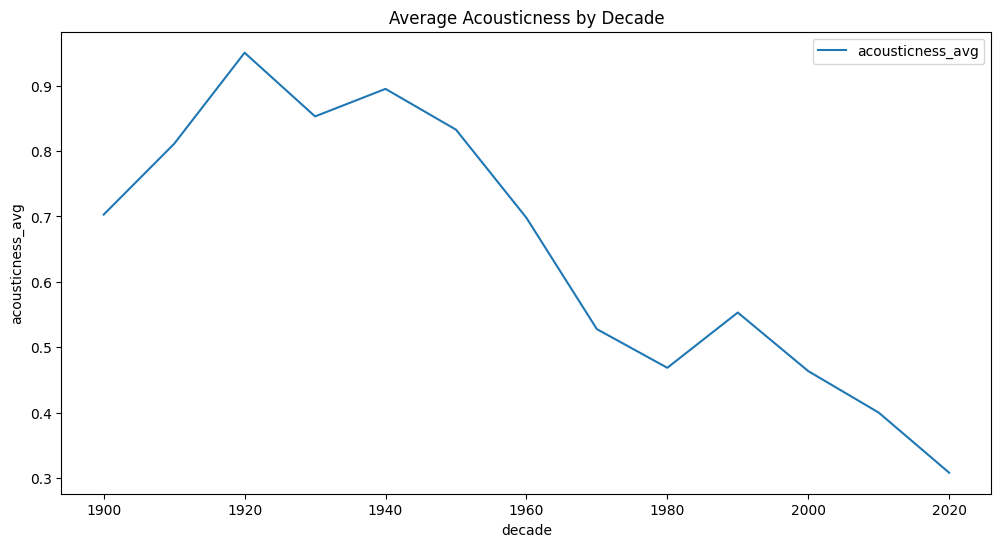

In [143]:
line_plot(average_features_by_decade, 'decade', ['acousticness_avg'], title='Average Acousticness by Decade')

### <a id='toc1_10_3_'></a>[Number of Releases Over Time](#toc0_)

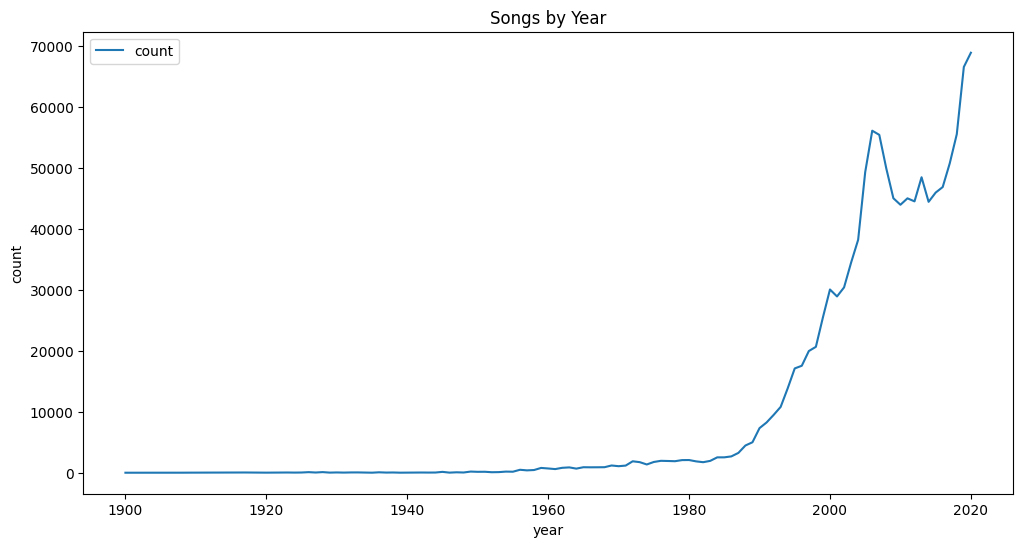

In [148]:
songs_by_year = df.groupBy('year').count().orderBy('year')
line_plot(songs_by_year, 'year', ['count'], title='Songs by Year')

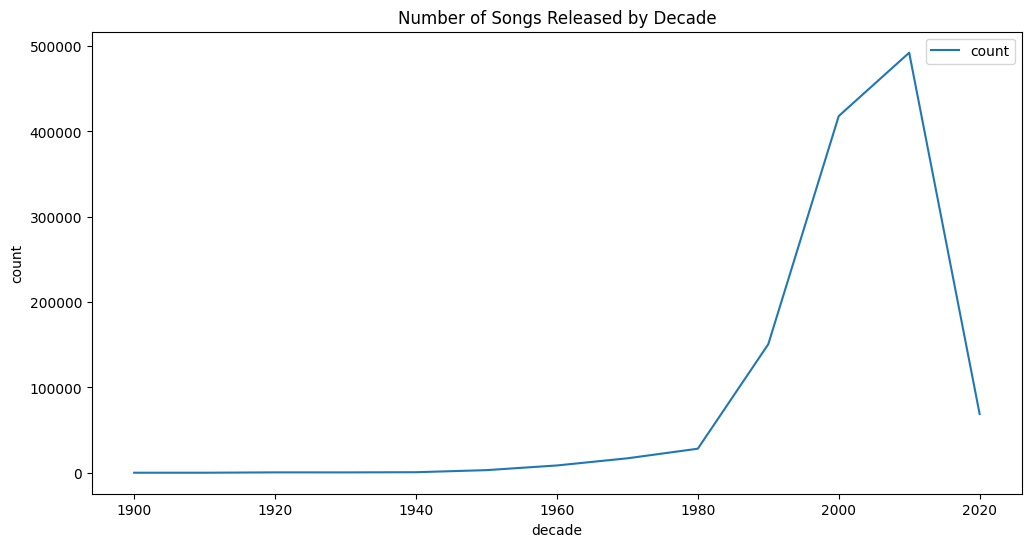

In [149]:
songs_by_decade = df.groupBy('decade').count().orderBy('decade')
line_plot(songs_by_decade, 'decade', ['count'], title='Number of Songs Released by Decade')

## <a id='toc1_11_'></a>[Other Interesting Insights](#toc0_)

### <a id='toc1_11_1_'></a>[Benford's law](#toc0_)


Benford's law is a mathematical law that describes the distribution of leading digits in many real-life sets of numerical data. According to Benford's law, the leading digit is more likely to be small than large. Specifically, the probability that the leading digit is `d` is given by:

$$P(d) = \log_{10}(1 + \frac{1}{d})$$

where `d` is the leading digit (1-9) and `P(d)` is the probability of the leading digit being `d`.

Benford's law is often used to detect fraud in financial data, but it can also be applied to other types of data, such as the number of songs released each year.

In [172]:
def benfords_law(df, col_name, figsize=(12, 6)):
	first_digit = df.withColumn('first_digit', substring(col(col_name).cast('string'), 1, 1))
	first_digit_counts = first_digit.groupBy('first_digit').agg(count('first_digit').alias('count'))
	total_count = first_digit_counts.agg({'count': 'sum'}).collect()[0]['sum(count)']
	benford_freq = {str(i): np.log10(1 + 1/i) * total_count for i in range(1, 10)}
	observed_freq = {row['first_digit']: row['count'] for row in first_digit_counts.collect()}
	digits = [str(i) for i in range(1, 10)]
	observed = [observed_freq[digit] for digit in digits]
	expected = [benford_freq[digit] for digit in digits]
	plt.figure(figsize=figsize)
	plt.bar(digits, observed, color='deepskyblue', alpha=0.5, label='Observed Frequency')
	plt.plot(digits, expected, color='deeppink', marker='o', label='Benford\'s Law Frequency')
	plt.xlabel('First Digit')
	plt.ylabel('Frequency')
	plt.title(f'Benford\'s Law for the First Digit of {col_name}')
	plt.legend()
	plt.show()

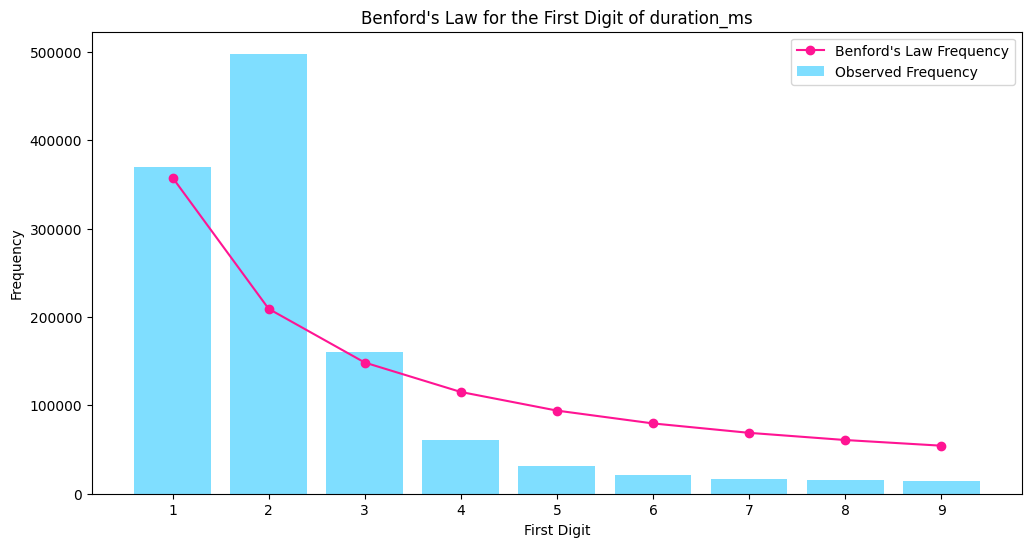

In [173]:
benfords_law(df, 'duration_ms')

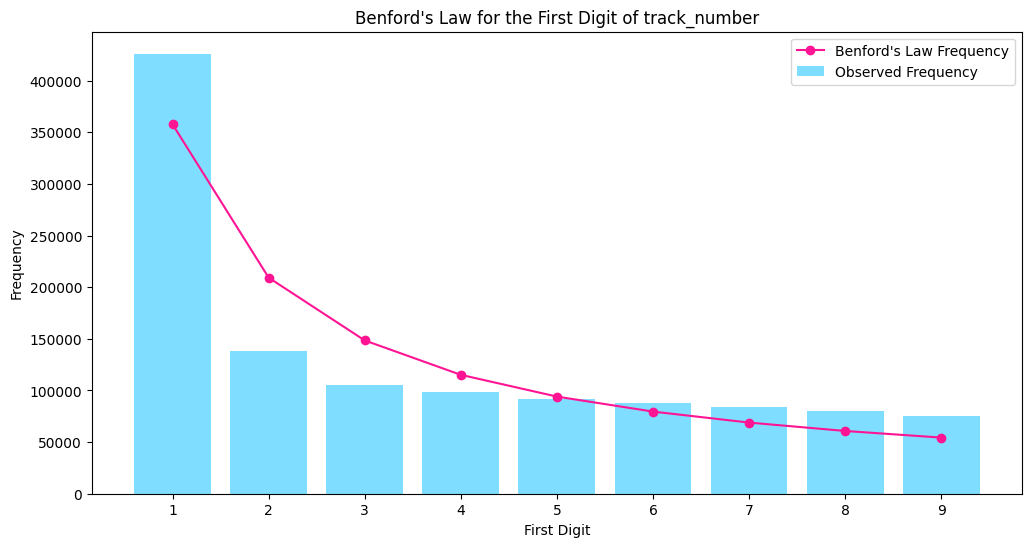

In [174]:
benfords_law(df, 'track_number')

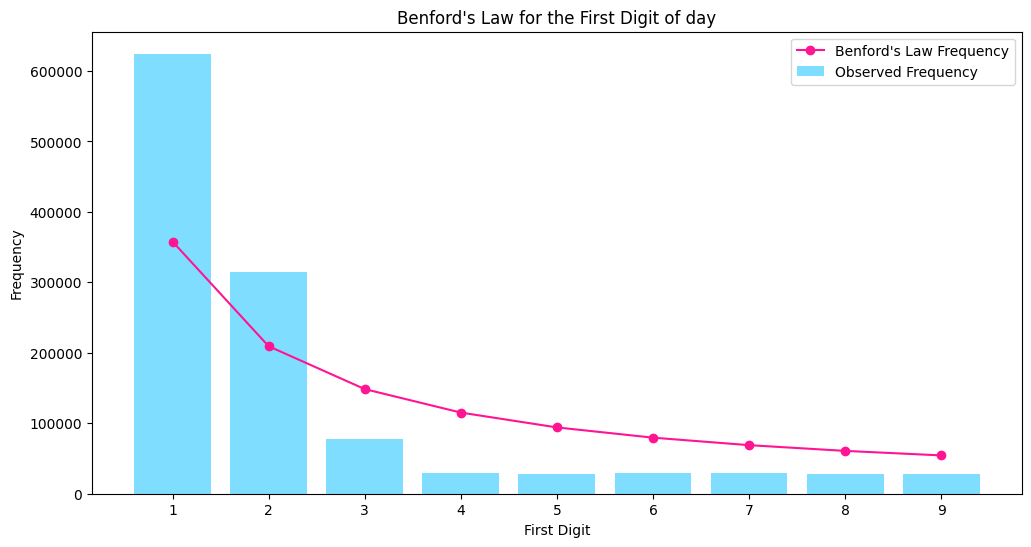

In [177]:
benfords_law(df, 'day')

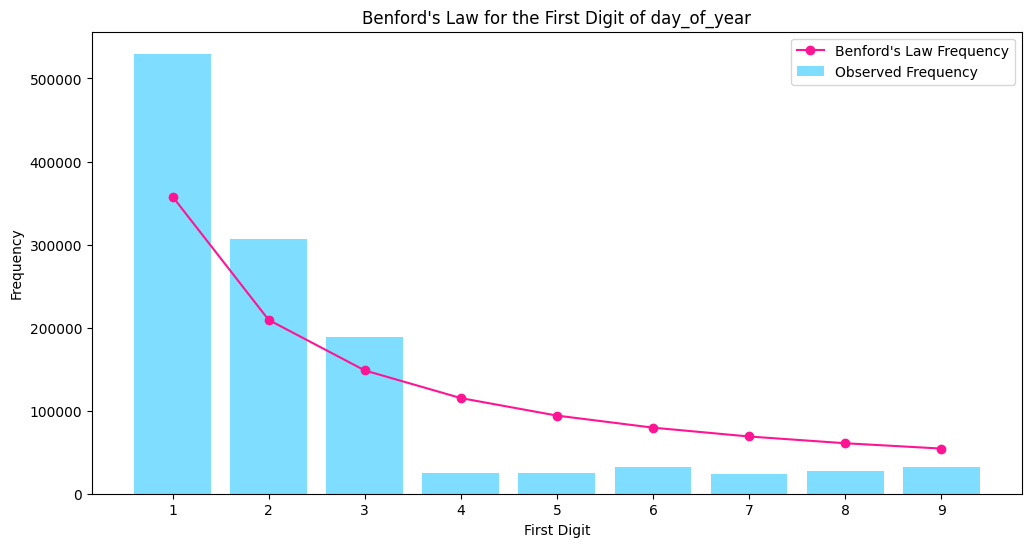

In [182]:
benfords_law(df, 'day_of_year')

## <a id='toc1_12_'></a>[Clustering](#toc0_)

In [152]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- album: string (nullable = true)
 |-- album_id: string (nullable = true)
 |-- artists: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- artist_ids: array (nullable = true)
 |    |-- element: string (containsNull = false)
 |-- track_number: long (nullable = true)
 |-- disc_number: long (nullable = true)
 |-- explicit: boolean (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: long (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: long (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- duration_ms: long (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- year: long (nul